# RNN - Model

In [1]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [4]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [6]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

In [7]:
# Drop features with more than 30% NaN values
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)


# Drop features with std = 0
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)


# Drop corrected features
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)


# Drop choke features
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)


# Drop correlated features
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)


# Drop features in remove dictionary
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", 
          "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", 
          "Downhole Gauge T", "Downhole Gauge P"}

df.drop(columns=remove, inplace=True)

In [8]:
df.shape

(5813, 17)

## Impute features with <30% NaN values

In [9]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)
    
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

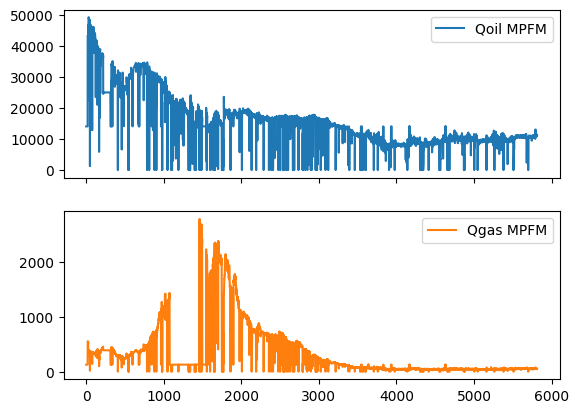

In [10]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

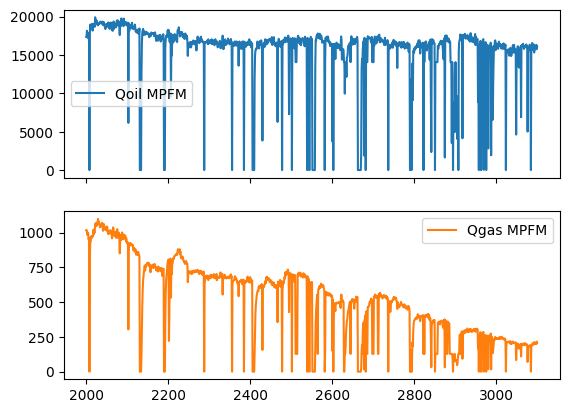

In [11]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset - Maybe delete

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [20]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [21]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [22]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [23]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [24]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [25]:
INPUT_LENGTH = 14 #two weeks

In [26]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [27]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [28]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [29]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [30]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [31]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [32]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [33]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [34]:
SEQUENCE_STRIDE = 1

In [35]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [36]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [37]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling LSTM - Maybe delete

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

#### Baseline model

In [42]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [43]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} barrels")

24/24 [==============================] - 0s 314us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3


2023-03-22 18:39:16.449186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Initial model from Weather prediction challenge but with batch_size=8 and epochs=150

In [44]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [45]:
model_init = init_model(X_train, y_train)
model_init.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [46]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model: models, verbose=1) -> tuple[models, dict]:
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [47]:
model_init, history_init = fit_model(model_init)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 995914304.0000 - mae: 30738.6191 - val_loss: 365787008.0000 - val_mae: 17616.0566
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987597056.0000 - mae: 30605.1953 - val_loss: 360920608.0000 - val_mae: 17504.1797
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 978200832.0000 - mae: 30454.7578 - val_loss: 355992000.0000 - val_mae: 17391.0195
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 968999360.0000 - mae: 30306.2988 - val_loss: 351088160.0000 - val_mae: 17275.3242
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 959917184.0000 - mae: 30159.0547 - val_loss: 346222336.0000 - val_mae: 17160.7754
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 950924928.0000 - mae: 30012.5273 - val_loss: 341432352.0000 - val_mae: 17047.0469
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 590305856.0000 - mae: 23389.2500 - val_loss: 160917296.0000 - val_mae: 11828.6914
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 583754112.0000 - mae: 23251.4102 - val_loss: 157734256.0000 - val_mae: 11706.8340
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 577246720.0000 - mae: 23113.6797 - val_loss: 154801488.0000 - val_mae: 11595.6113
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 570783488.0000 - mae: 22976.0020 - val_loss: 151957408.0000 - val_mae: 11489.1650
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 564363840.0000 - mae: 22838.4238 - val_loss: 149187168.0000 - val_mae: 11385.1221
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 557987904.0000 - mae: 22700.9336 - val_loss: 146438384.0000 - val_mae: 11280.0547
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

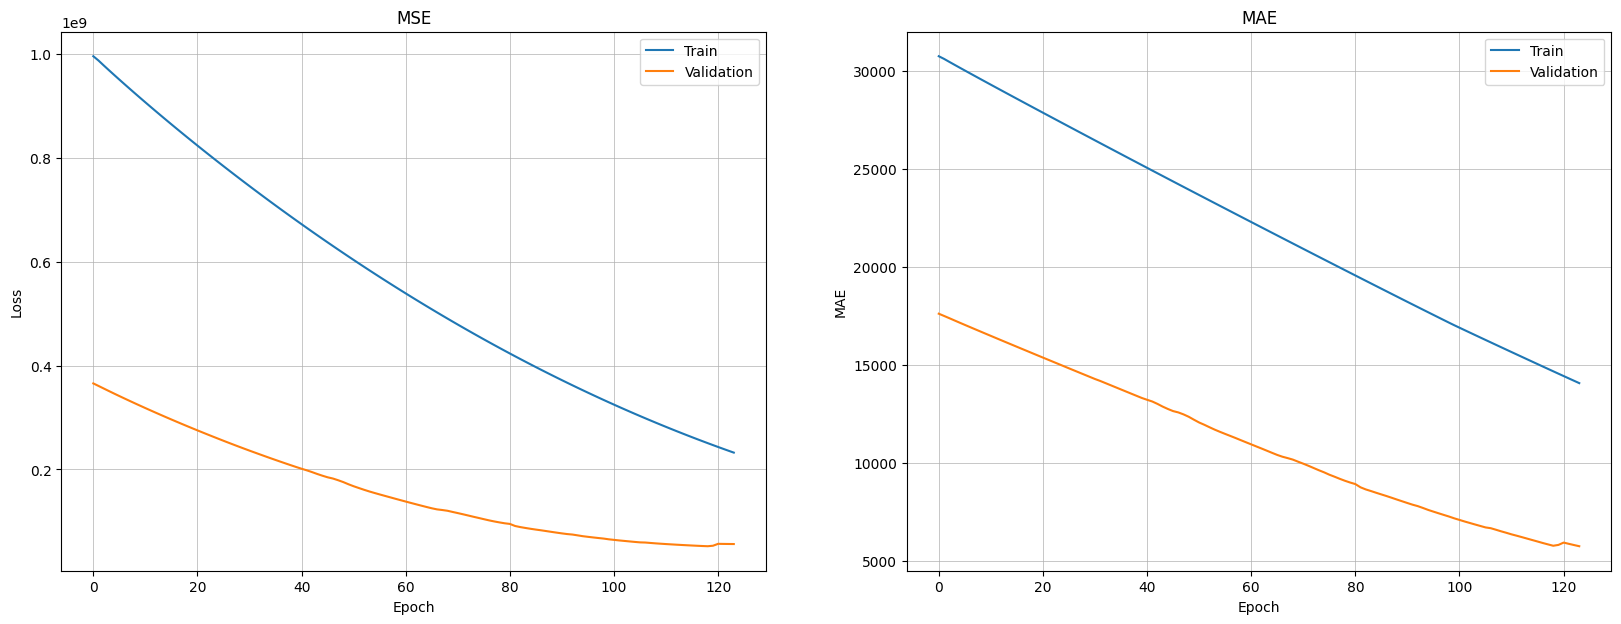

In [48]:
plot_history(history_init)

In [49]:
res = model_init.evaluate(X_test, y_test, verbose=0)
res

[21534168.0, 2683.525634765625]

In [50]:
mae_results = {}

In [51]:
mae_results['res'] = res[1]

#### Initial model with LSTM 128 neurons

In [52]:
def init_model_2(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [53]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [55]:
model_2, history_2 = fit_model(model_2)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 995156288.0000 - mae: 30726.2832 - val_loss: 369061408.0000 - val_mae: 17694.3457
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 989057920.0000 - mae: 30634.7598 - val_loss: 363064640.0000 - val_mae: 17557.5078
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 980935808.0000 - mae: 30497.6758 - val_loss: 355758784.0000 - val_mae: 17391.5820
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 969476160.0000 - mae: 30313.6016 - val_loss: 349794560.0000 - val_mae: 17254.6211
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 959392832.0000 - mae: 30150.3105 - val_loss: 344288192.0000 - val_mae: 17126.9316
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 949878848.0000 - mae: 29995.3203 - val_loss: 339039776.0000 - val_mae: 17004.0918
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 595354816.0000 - mae: 23494.9473 - val_loss: 159794512.0000 - val_mae: 11895.1807
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 588857600.0000 - mae: 23358.9004 - val_loss: 156974320.0000 - val_mae: 11791.9414
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 582405248.0000 - mae: 23222.9785 - val_loss: 154195360.0000 - val_mae: 11688.9033
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 575996800.0000 - mae: 23087.1582 - val_loss: 151457632.0000 - val_mae: 11587.4619
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 569632896.0000 - mae: 22951.4668 - val_loss: 148760944.0000 - val_mae: 11486.4229
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 563313024.0000 - mae: 22815.8809 - val_loss: 146105200.0000 - val_mae: 11385.4658
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

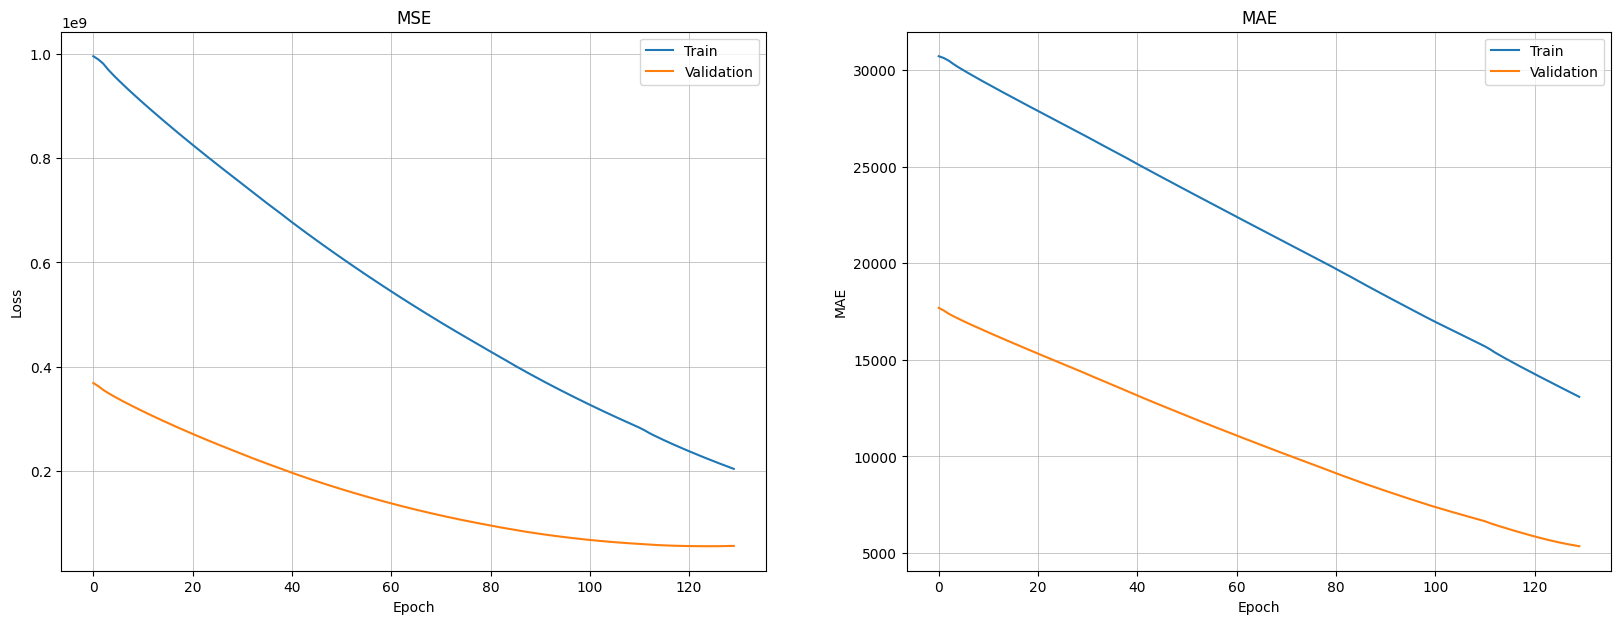

In [56]:
plot_history(history_2)

In [57]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[24139206.0, 2534.969482421875]

In [58]:
mae_results['res2'] = res2[1]

#### Initial model but with one more LSTM layer

In [59]:
def init_model_3(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [60]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 117,064
Trainable params: 117,057
Non-trainable params: 7
________________________________________________

In [61]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [62]:
model_3, history_3 = fit_model(model_3)

Epoch 1/150
125/125 [==============================] - 2s 9ms/step - loss: 996257088.0000 - mae: 30744.3574 - val_loss: 365776640.0000 - val_mae: 17618.6133
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 987880256.0000 - mae: 30610.2227 - val_loss: 360705888.0000 - val_mae: 17504.1738
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 979107200.0000 - mae: 30469.4629 - val_loss: 355745600.0000 - val_mae: 17391.3047
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 970450816.0000 - mae: 30329.9043 - val_loss: 350850112.0000 - val_mae: 17278.9941
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 961869760.0000 - mae: 30190.9082 - val_loss: 346010720.0000 - val_mae: 17167.0430
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 953354944.0000 - mae: 30052.3301 - val_loss: 341224256.0000 - val_mae: 17055.3926
Epoch 7/150
125/125 [==============================] - 1s 

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 607286016.0000 - mae: 23742.7969 - val_loss: 165082608.0000 - val_mae: 12085.0352
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 600935360.0000 - mae: 23611.2715 - val_loss: 162285696.0000 - val_mae: 11985.2109
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 594624960.0000 - mae: 23479.8262 - val_loss: 159526768.0000 - val_mae: 11885.4404
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 588354240.0000 - mae: 23348.4414 - val_loss: 156805728.0000 - val_mae: 11785.7256
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 582123392.0000 - mae: 23217.1426 - val_loss: 154122624.0000 - val_mae: 11686.2061
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 575932672.0000 - mae: 23085.9199 - val_loss: 151477360.0000 - val_mae: 11588.1992
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

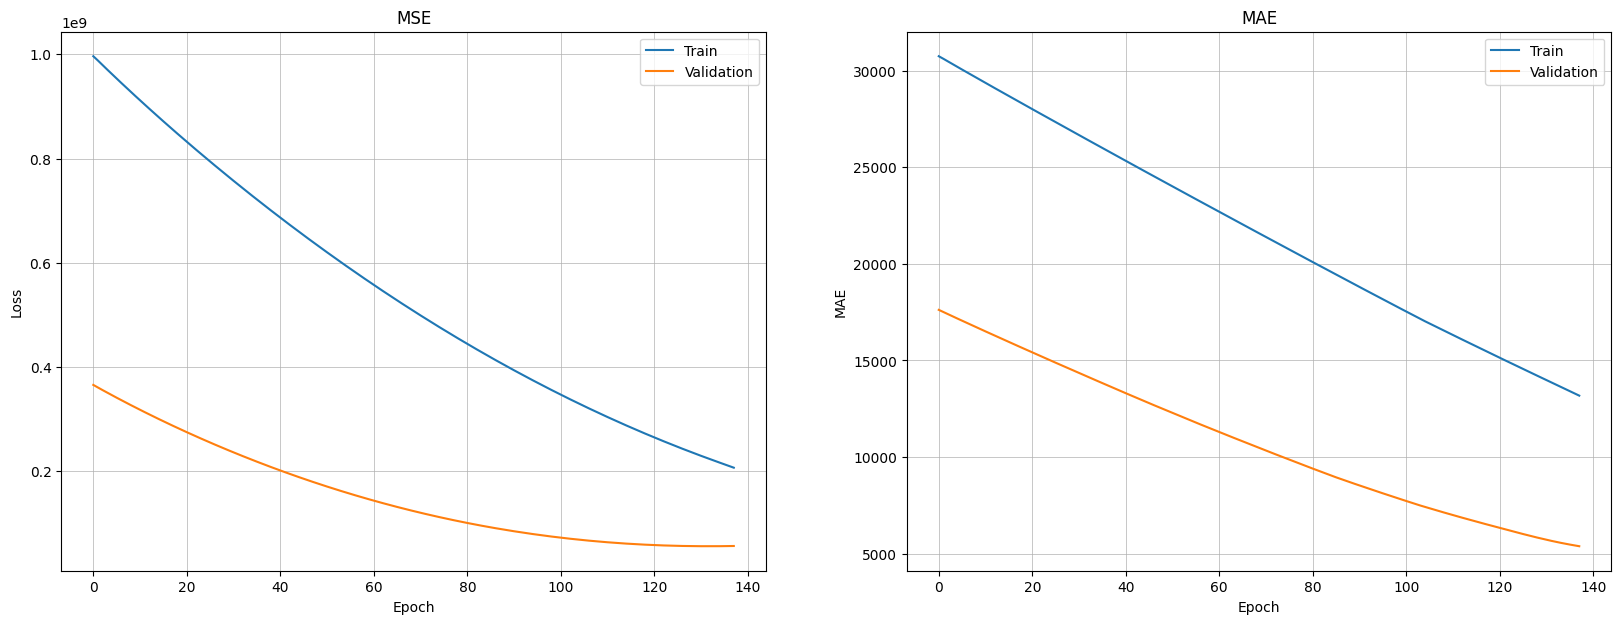

In [63]:
plot_history(history_3)

In [64]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[24067118.0, 2532.26953125]

In [65]:
mae_results['res3'] = res3[1]

In [66]:
print(mae_results)

{'res': 2683.525634765625, 'res2': 2534.969482421875, 'res3': 2532.26953125}


#### Add more layers

In [67]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [68]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [69]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [70]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 2s 10ms/step - loss: 996696384.0000 - mae: 30752.1035 - val_loss: 368433440.0000 - val_mae: 17678.4316
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 991746240.0000 - mae: 30670.5547 - val_loss: 364055008.0000 - val_mae: 17580.3008
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 984514624.0000 - mae: 30554.9434 - val_loss: 360502880.0000 - val_mae: 17500.1113
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 977177088.0000 - mae: 30438.1973 - val_loss: 357074496.0000 - val_mae: 17422.3203
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 970153920.0000 - mae: 30324.4551 - val_loss: 353515520.0000 - val_mae: 17341.0215
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 962992320.0000 - mae: 30208.3691 - val_loss: 349805376.0000 - val_mae: 17255.6875
Epoch 7/150
125/125 [==============================] - 1s

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 596156416.0000 - mae: 23506.7461 - val_loss: 189480240.0000 - val_mae: 12960.0430
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 588868032.0000 - mae: 23357.4316 - val_loss: 186782560.0000 - val_mae: 12874.0078
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 584070656.0000 - mae: 23257.7930 - val_loss: 184113664.0000 - val_mae: 12787.1504
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 576258752.0000 - mae: 23089.4746 - val_loss: 181462704.0000 - val_mae: 12700.2080
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 570511680.0000 - mae: 22966.7930 - val_loss: 178841280.0000 - val_mae: 12613.5439
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 563674880.0000 - mae: 22826.1133 - val_loss: 176246320.0000 - val_mae: 12526.8213
Epoch 59/150
125/125 [==============================

Epoch 105/150
125/125 [==============================] - 1s 6ms/step - loss: 312801856.0000 - mae: 16554.3359 - val_loss: 85180064.0000 - val_mae: 8620.4072
Epoch 106/150
125/125 [==============================] - 1s 6ms/step - loss: 307942208.0000 - mae: 16417.6523 - val_loss: 83905672.0000 - val_mae: 8542.9648
Epoch 107/150
125/125 [==============================] - 1s 6ms/step - loss: 305090848.0000 - mae: 16328.7354 - val_loss: 82704120.0000 - val_mae: 8467.8555
Epoch 108/150
125/125 [==============================] - 1s 6ms/step - loss: 299282496.0000 - mae: 16163.0234 - val_loss: 81551656.0000 - val_mae: 8394.1074
Epoch 109/150
125/125 [==============================] - 1s 6ms/step - loss: 296044576.0000 - mae: 16055.6338 - val_loss: 80423472.0000 - val_mae: 8320.4736
Epoch 110/150
125/125 [==============================] - 1s 6ms/step - loss: 292048736.0000 - mae: 15948.3193 - val_loss: 79231792.0000 - val_mae: 8241.3730
Epoch 111/150
125/125 [==============================] - 1

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

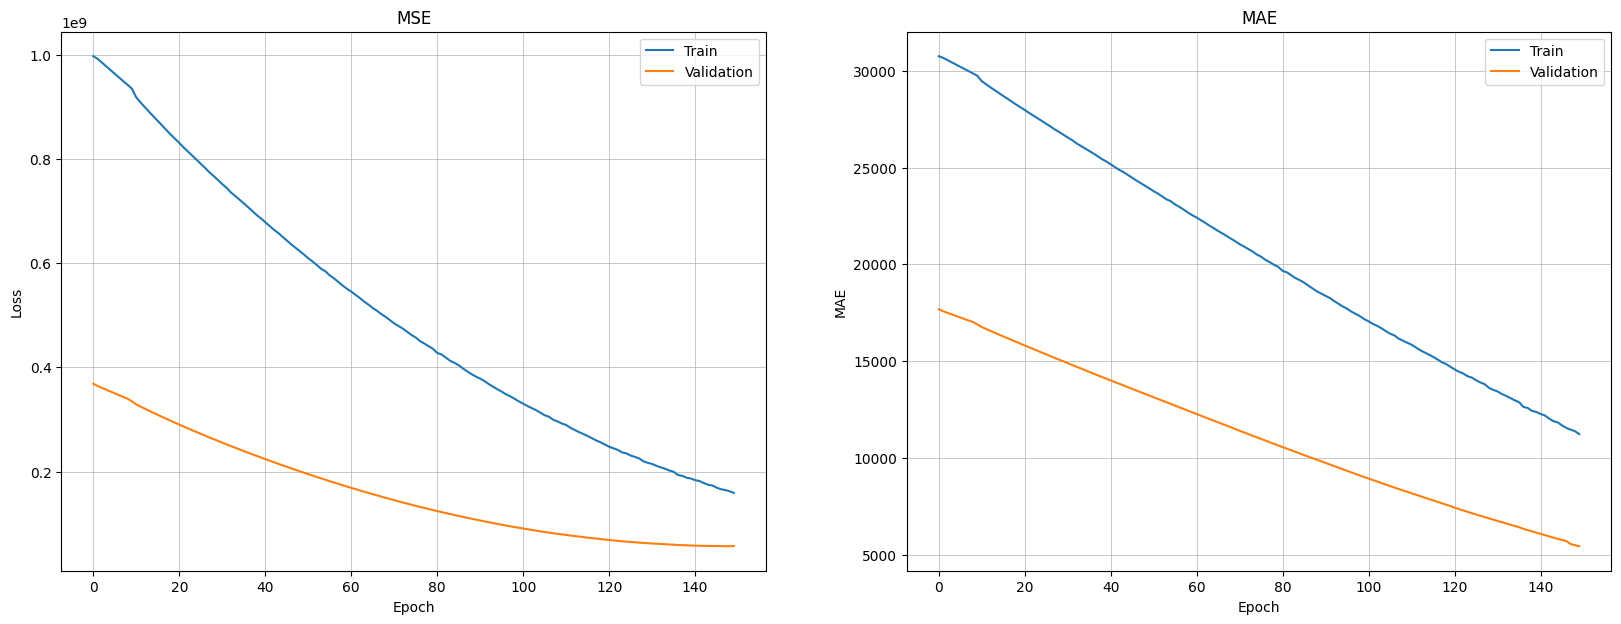

In [71]:
plot_history(history_4)

In [72]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[29043988.0, 3518.168701171875]

In [73]:
mae_results['res4'] = res4[1]

In [74]:
mae_results

{'res': 2683.525634765625,
 'res2': 2534.969482421875,
 'res3': 2532.26953125,
 'res4': 3518.168701171875}

#### Test with more features

In [202]:
df[['MPFM Venturi dP', 'WHT', 'Tubing Gradient']]

,MPFM Venturi dP,WHT,Tubing Gradient
0,1672.997986,51.247467,0.000000
1,1672.997986,51.247467,0.000000
2,1672.997986,51.247467,0.000000
3,1672.997986,51.247467,0.000000
4,1672.997986,51.247467,0.000000
...,...,...,...
5808,1687.935181,51.966740,1.003753
5809,1719.284912,51.968021,1.003906
5810,1742.380127,51.972717,1.005642
5811,1729.632324,51.982071,1.006597


In [296]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.15)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [297]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_50 (LSTM)              (None, 128)               67584     
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [298]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [299]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 964556736.0000 - mae: 30215.6406 - val_loss: 327854688.0000 - val_mae: 16739.6250
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 888815744.0000 - mae: 28958.2363 - val_loss: 287320896.0000 - val_mae: 15736.3643
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 816949440.0000 - mae: 27715.8789 - val_loss: 250696144.0000 - val_mae: 14758.2383
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 750925632.0000 - mae: 26525.0508 - val_loss: 222630672.0000 - val_mae: 13856.2500
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 685689728.0000 - mae: 25276.5391 - val_loss: 185955088.0000 - val_mae: 12695.2217
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 615159552.0000 - mae: 23872.2168 - val_loss: 155759152.0000 - val_mae: 11630.9375
Epoch 7/150
125/125 [==============================] - 0s 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

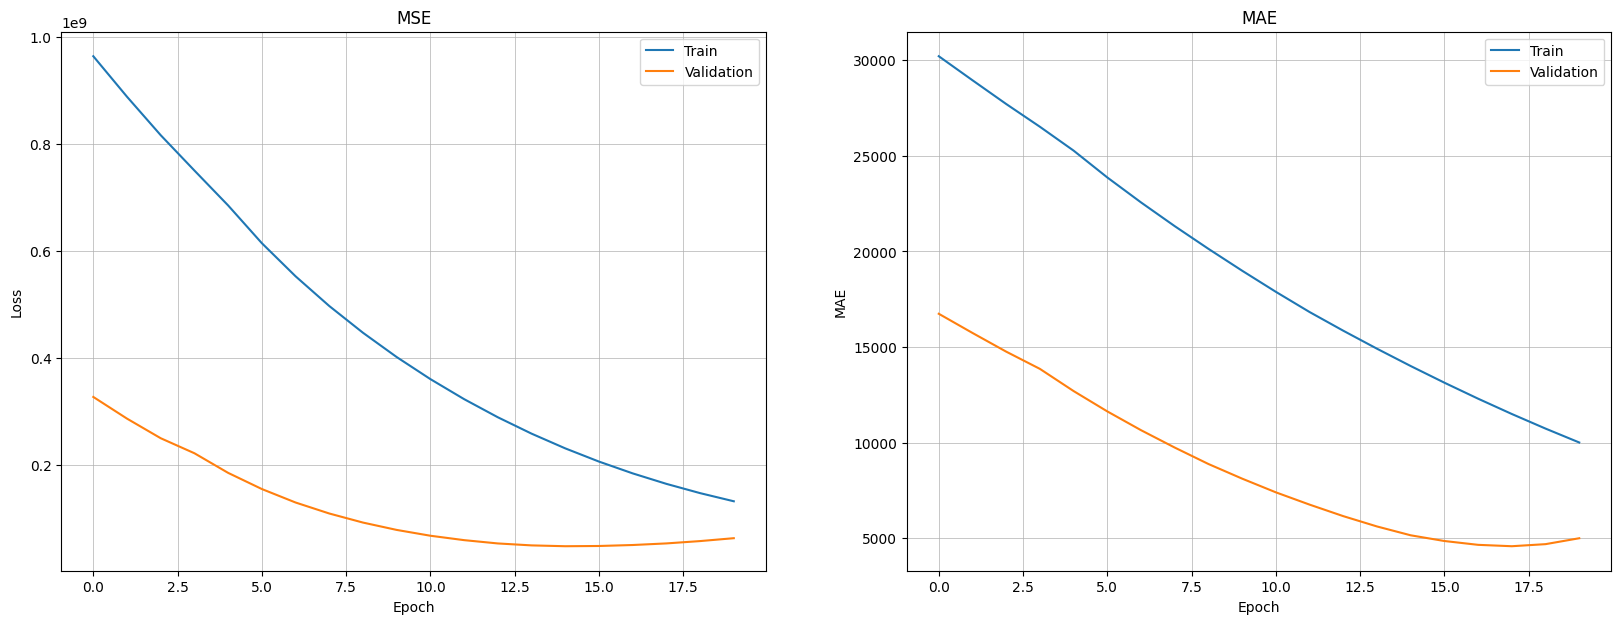

In [300]:
plot_history(history_4)

In [309]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[22892092.0, 2442.34619140625]

In [312]:
mae_results['res4'] = res4[1]

In [313]:
mae_results

{'res': 2532.921142578125,
 'res2': 2594.729736328125,
 'res3': 2493.5693359375,
 'res4': 2442.34619140625}

#### Applying a scaler to the df

In [565]:
FOLD_LENGTH

2190

In [566]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(df_LSTM)
df_LSTM_scaled = std_scaler.transform(df_LSTM)

In [567]:
df_LSTM_scaled = pd.DataFrame(df_LSTM_scaled, columns=df_LSTM.columns)

In [568]:
folds_longer = get_folds(df_LSTM_scaled, 365*3, FOLD_STRIDE)
fold_longer = folds_longer[0]
(fold_train_longer, fold_test_longer) = train_test_split(fold_longer, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_c, y_train_c = get_X_y_strides(fold_train_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_c, y_test_c = get_X_y_strides(fold_test_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_c.shape)
print(y_train_c.shape)

(708, 14, 3)
(708, 1, 1)


In [569]:
N_FEATURES

3

In [559]:
def init_model_5(X_train, y_train):
    
    #normalization
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    #model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', input_shape=(X_train_c.shape[1], X_train_c.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [560]:
model_5 = init_model_5(X_train_c, y_train_c)
model_5.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [561]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_mae", mode = "min")

def fit_model(model):
    
    history = model.fit(X_train_c, y_train_c,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=250,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [562]:
model_5, history_5 = fit_model(model_5)

Epoch 1/250
62/62 [==============================] - 2s 7ms/step - loss: 0.9333 - mae: 0.6695 - val_loss: 0.6518 - val_mae: 0.7323
Epoch 2/250
62/62 [==============================] - 0s 4ms/step - loss: 1.0010 - mae: 0.7356 - val_loss: 0.3131 - val_mae: 0.4198
Epoch 3/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9121 - mae: 0.7171 - val_loss: 0.3013 - val_mae: 0.3857
Epoch 4/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8924 - mae: 0.7198 - val_loss: 0.3543 - val_mae: 0.4467
Epoch 5/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8647 - mae: 0.6832 - val_loss: 0.2928 - val_mae: 0.3871
Epoch 6/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8888 - mae: 0.6834 - val_loss: 0.3434 - val_mae: 0.4574
Epoch 7/250
62/62 [==============================] - 0s 4ms/step - loss: 0.7312 - mae: 0.6160 - val_loss: 0.5694 - val_mae: 0.6840
Epoch 8/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9909 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

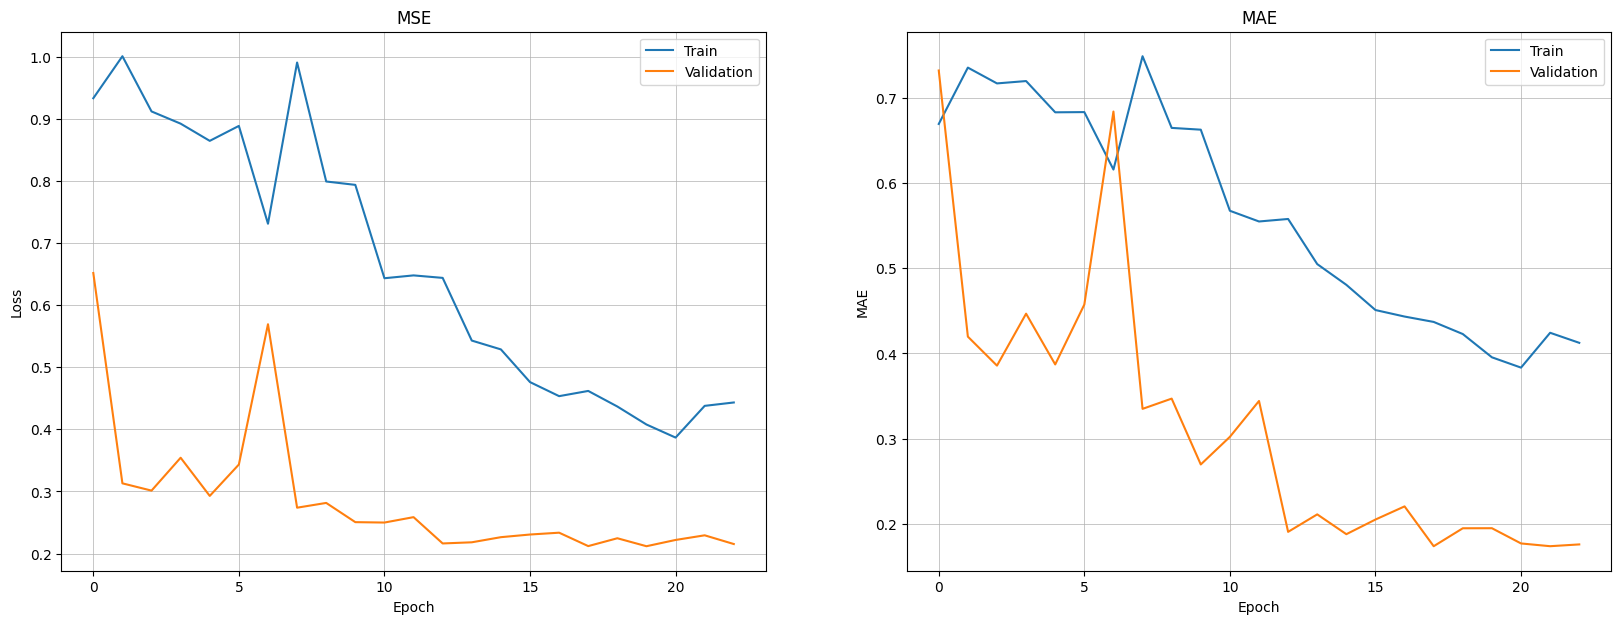

In [563]:
plot_history(history_5)

In [564]:
res5 = model_5.evaluate(X_test_c, y_test_c, verbose=0)
res5

[0.5426031947135925, 0.49569591879844666]

In [550]:
predicted_values = pd.DataFrame(model_5.predict(X_test_c))


12/12 [==============================] - 0s 989us/step


## Ben's code

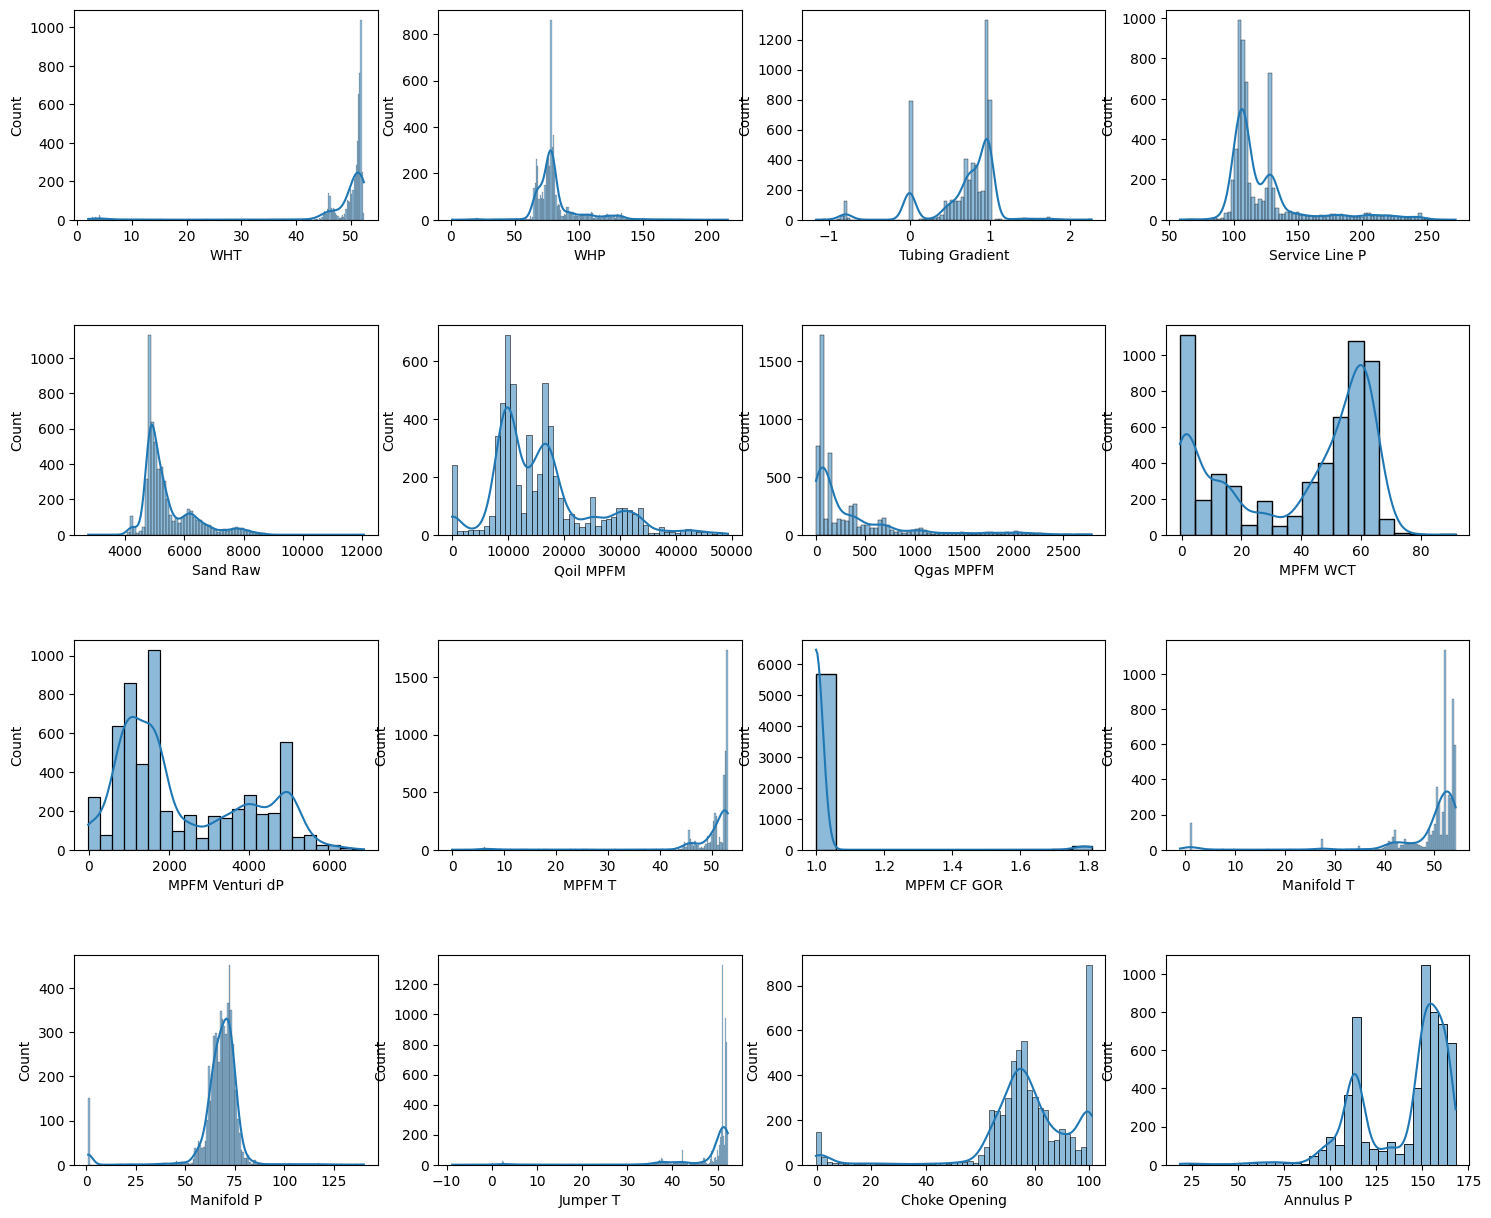

In [10]:
# Create a figure and axis for each histogram
fig, axs = plt.subplots(4, 4, figsize=(18, 15))

axs = axs.ravel()

for i, col in enumerate(df.drop(columns=['Date']).columns):
    sns.histplot(df.drop(columns=['Date'])[col], kde=True, ax=axs[i])

for j in range(len(df.drop(columns=['Date']).columns), len(axs)):
    axs[j].axis('off')

plt.subplots_adjust(hspace=0.5)

plt.show()

### Select df_train and df_test

In [11]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [12]:
def plot_predictions(y_test, y_pred):
    plt.plot(y_test, c='red', label='Test')
    plt.plot(y_pred, c='blue', label='Pred')
    plt.legend()
    plt.show()

In [13]:
train_start_date = pd.to_datetime('2007-02-01')
train_end_date = pd.to_datetime('2019-12-31')
test_start_date = pd.to_datetime('2020-01-01')
test_end_date = pd.to_datetime('2022-12-31')

#train_start_date = pd.to_datetime('2010-01-01')
#train_end_date = pd.to_datetime('2022-12-31')
#test_start_date = pd.to_datetime('2007-02-01')
#test_end_date = pd.to_datetime('2009-12-31')

df_train = df[(df['Date']>=train_start_date) & (df['Date']<=train_end_date)]
df_test = df[(df['Date']>=test_start_date) & (df['Date']<=test_end_date)]

### Scaling with MinMaxScaler:

Use the cell below to scale the data before getting the sequences

In [14]:
#scaler_X = MinMaxScaler(feature_range=(0,1))
#X_train_scaled = pd.DataFrame(scaler_X.fit_transform(df_train.drop(columns='Date')), columns=df_train.drop(columns='Date').columns)
#X_test_scaled = pd.DataFrame(scaler_X.transform(df_test.drop(columns='Date')), columns=df_test.drop(columns='Date').columns)

#scaler_y = MinMaxScaler(feature_range=(0,1))
#y_train_scaled = pd.DataFrame(scaler_y.fit_transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])
#y_test_scaled = pd.DataFrame(scaler_y.transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])

In [15]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date'])
    #iloc[random_start:random_start + length, :] 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train, 3, 1)

(            WHT        WHP  Tubing Gradient  Service Line P     Sand Raw  \
 2863  51.028679  73.797112         0.807311      122.390320  5124.187500   
 2864  51.025307  73.722336         0.807003      122.884178  5097.014160   
 2865  51.029205  73.801643         0.806013      123.099617  5138.928223   
 
          Qoil MPFM   Qgas MPFM   MPFM WCT  MPFM Venturi dP     MPFM T  \
 2863  16629.036189  339.869039  49.647053      3205.829346  51.883743   
 2864  16534.047531  359.488875  49.333500      3020.030518  51.865337   
 2865  16830.508610  354.356578  48.811920      3041.770752  51.876637   
 
       MPFM CF GOR  Manifold T  Manifold P   Jumper T  Choke Opening  \
 2863          1.0   51.940947   69.975616  51.085567     100.230400   
 2864          1.0   51.940947   69.988876  51.085567     100.129456   
 2865          1.0   51.940947   69.904068  51.085567     100.318176   
 
        Annulus P  
 2863  161.592636  
 2864  161.566269  
 2865  161.565353  ,
 2866    16852.423134

In [16]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [17]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [18]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [19]:
y_train.shape

(5000, 1)

In [20]:
X_test.shape

(1000, 500, 16)

In [21]:
# check shape after reshaping
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_train_reshape.shape

(5000, 8000)

Scaling the data after getting the sequences

In [22]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
#scaler_X = RobustScaler()
#scaler_y = RobustScaler()
#scaler_X = StandardScaler()
#scaler_y = StandardScaler()


X_train = scaler_X.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1,y_test.shape[1])).reshape(y_test.shape)

### Baseline model

In [23]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [24]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)}")

32/32 [==============================] - 0s 476us/step - loss: 0.0033 - mae: 0.0370
- The Baseline MAE on the test set is equal to 0.04


2023-03-26 19:01:29.459738: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
res = {}

res['baseline_score'] = baseline_score[1]

### Model 1 - First LSTM model

In [26]:
def init_model_1(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [27]:
model_1 = init_model_1(X_train, y_train)
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2,129
Trainable params: 2,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [29]:
model_1, history_1 = fit_model(model_1)

Epoch 1/50
110/110 [==============================] - 6s 49ms/step - loss: 0.0723 - mae: 0.1815 - val_loss: 0.0280 - val_mae: 0.1166
Epoch 2/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0244 - mae: 0.1088 - val_loss: 0.0137 - val_mae: 0.0775
Epoch 3/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0162 - mae: 0.0844 - val_loss: 0.0110 - val_mae: 0.0654
Epoch 4/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0127 - mae: 0.0724 - val_loss: 0.0120 - val_mae: 0.0737
Epoch 5/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0118 - mae: 0.0687 - val_loss: 0.0122 - val_mae: 0.0741
Epoch 6/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0122 - mae: 0.0702 - val_loss: 0.0104 - val_mae: 0.0535
Epoch 7/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0117 - mae: 0.0671 - val_loss: 0.0102 - val_mae: 0.0560
Epoch 8/50
110/110 [==============================] - 5s 47ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

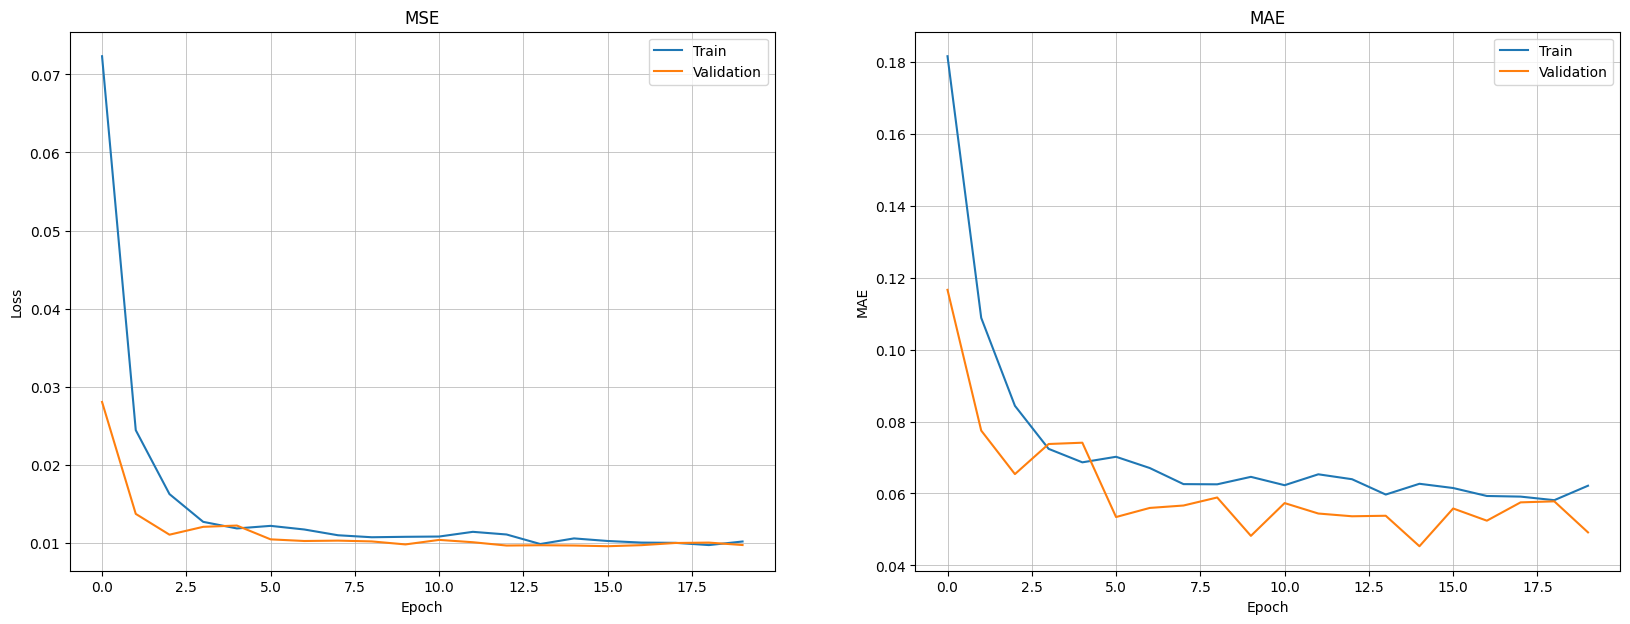

In [30]:
plot_history(history_1)

In [31]:
res1 = model_1.evaluate(X_test, y_test, verbose=0)
res1

[0.002484219614416361, 0.04049758240580559]

In [32]:
res['model_1_score'] = res1[1]

In [33]:
y_pred_1 = model_1.predict(X_test)
y_pred_1

32/32 [==============================] - 0s 9ms/step


array([[ 0.26976627],
       [ 0.29554802],
       [ 0.26759657],
       [ 0.25809252],
       [ 0.25693122],
       [ 0.26710427],
       [ 0.27236828],
       [ 0.2569348 ],
       [ 0.27843   ],
       [ 0.28496504],
       [ 0.25504938],
       [ 0.28036737],
       [ 0.25635558],
       [ 0.26834953],
       [ 0.19929609],
       [ 0.26017973],
       [ 0.03374323],
       [ 0.27131322],
       [ 0.25559035],
       [ 0.27320102],
       [ 0.03374323],
       [ 0.25137976],
       [ 0.01328748],
       [ 0.24625778],
       [ 0.255605  ],
       [ 0.2542687 ],
       [ 0.28474277],
       [ 0.21574217],
       [ 0.26193142],
       [ 0.27590644],
       [ 0.26000902],
       [ 0.25750875],
       [ 0.28294712],
       [ 0.27957577],
       [ 0.26237226],
       [ 0.24725026],
       [ 0.26261187],
       [ 0.27635288],
       [ 0.2544653 ],
       [ 0.27258244],
       [ 0.26832464],
       [ 0.2782364 ],
       [ 0.26904157],
       [ 0.27635288],
       [ 0.27991208],
       [ 0

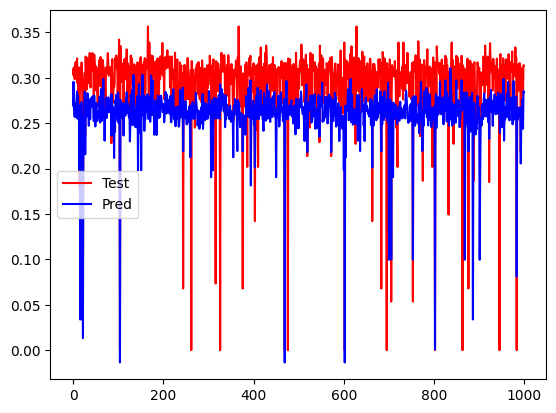

In [34]:
plot_predictions(y_test,y_pred_1)

In [35]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_1_unscaled = scaler_y.inverse_transform(y_pred_1)

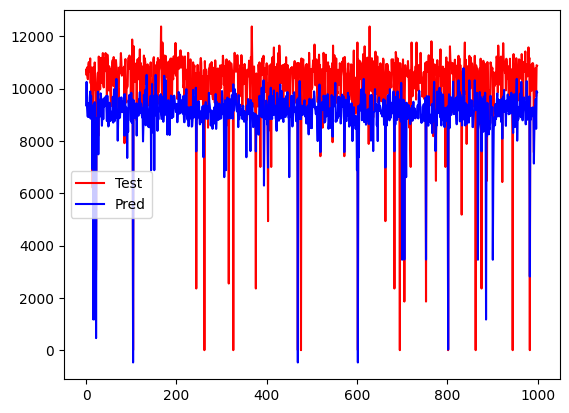

In [36]:
plot_predictions(y_test_unscaled, y_pred_1_unscaled)

### Model 2 - Changing number of neurons

In [37]:
def init_model_2(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    #model.add(layers.LSTM(8, activation='tanh'))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [38]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [39]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [40]:
model_2, history_2 = fit_model(model_2)

Epoch 1/50
110/110 [==============================] - 6s 45ms/step - loss: 0.0373 - mae: 0.1352 - val_loss: 0.0136 - val_mae: 0.0799
Epoch 2/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0149 - mae: 0.0809 - val_loss: 0.0114 - val_mae: 0.0669
Epoch 3/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0127 - mae: 0.0728 - val_loss: 0.0104 - val_mae: 0.0592
Epoch 4/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0127 - mae: 0.0709 - val_loss: 0.0115 - val_mae: 0.0747
Epoch 5/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0116 - mae: 0.0659 - val_loss: 0.0099 - val_mae: 0.0575
Epoch 6/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0119 - mae: 0.0697 - val_loss: 0.0102 - val_mae: 0.0598
Epoch 7/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0121 - mae: 0.0663 - val_loss: 0.0098 - val_mae: 0.0576
Epoch 8/50
110/110 [==============================] - 5s 43ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

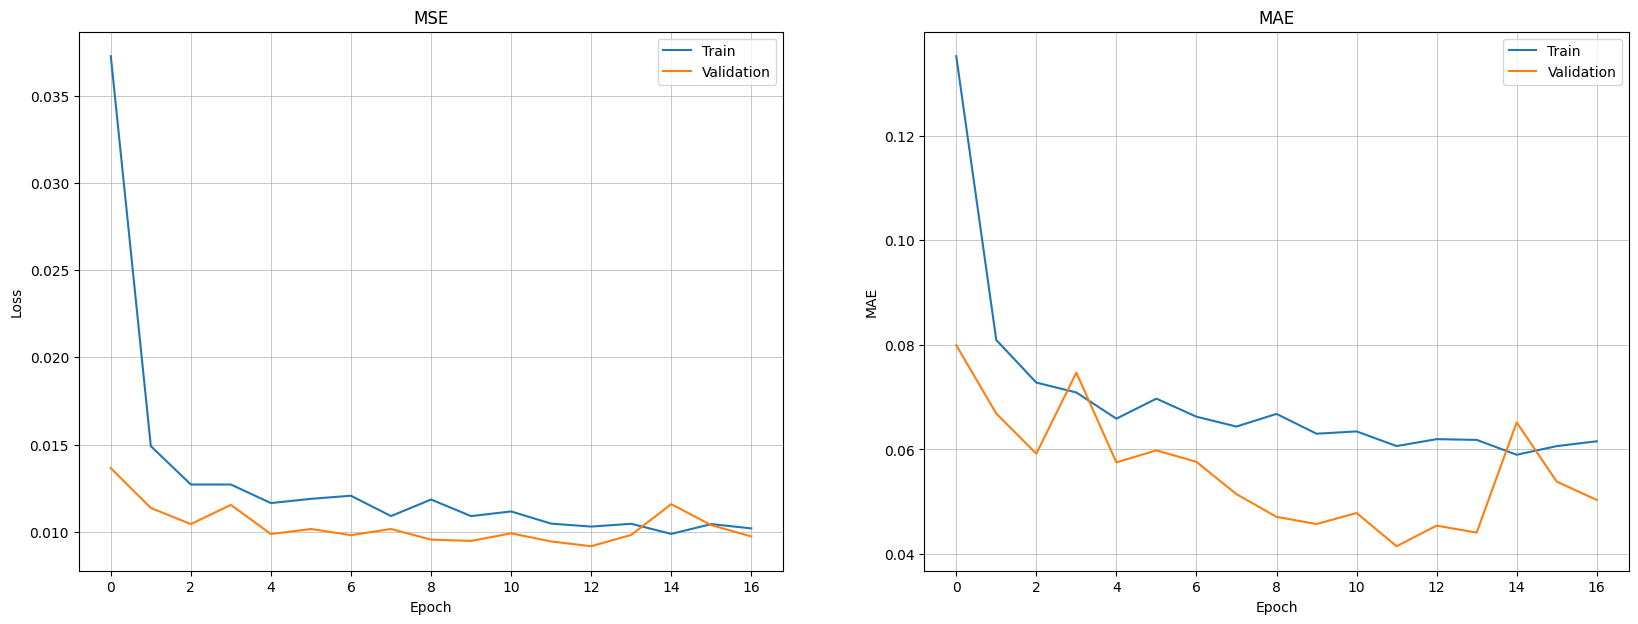

In [41]:
plot_history(history_2)

In [42]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[0.0016780702862888575, 0.02823290042579174]

In [43]:
res['model_2_score'] = res2[1]

In [44]:
y_pred_2 = model_2.predict(X_test)
y_pred_2

32/32 [==============================] - 0s 8ms/step


array([[0.2586884 ],
       [0.307573  ],
       [0.28930026],
       [0.28033817],
       [0.28294206],
       [0.2863034 ],
       [0.29405683],
       [0.28586552],
       [0.2694012 ],
       [0.2712252 ],
       [0.2749955 ],
       [0.27120948],
       [0.27912295],
       [0.2910515 ],
       [0.2433141 ],
       [0.27692974],
       [0.15340242],
       [0.29286402],
       [0.2853288 ],
       [0.2694153 ],
       [0.15340242],
       [0.2685437 ],
       [0.19936374],
       [0.2681586 ],
       [0.27902758],
       [0.2824035 ],
       [0.26906815],
       [0.2368246 ],
       [0.28727204],
       [0.26741612],
       [0.2793227 ],
       [0.2813049 ],
       [0.27438688],
       [0.2655705 ],
       [0.2817072 ],
       [0.27134293],
       [0.28282288],
       [0.29219446],
       [0.2763705 ],
       [0.26880965],
       [0.29233927],
       [0.27169544],
       [0.29755336],
       [0.29219446],
       [0.27400732],
       [0.28901753],
       [0.27328837],
       [0.279

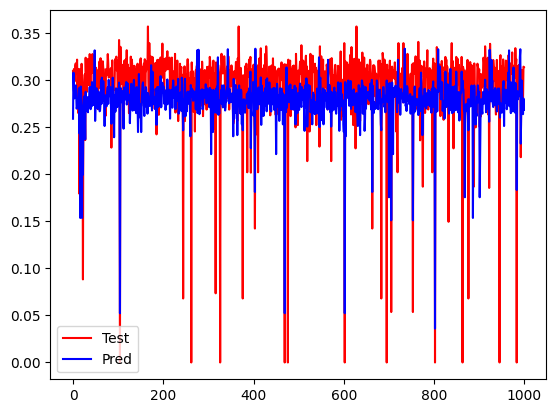

In [45]:
plot_predictions(y_test, y_pred_2)

In [46]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_2_unscaled = scaler_y.inverse_transform(y_pred_2)

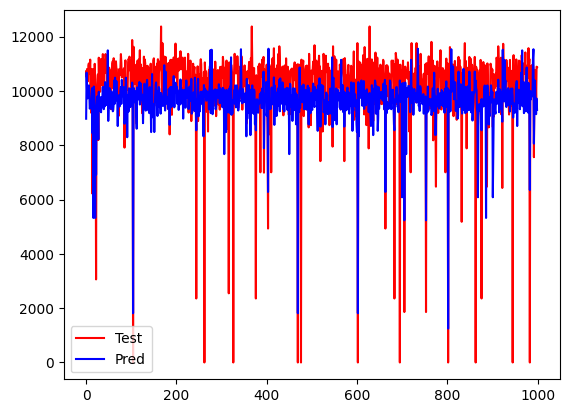

In [47]:
plot_predictions(y_test_unscaled, y_pred_2_unscaled)

### Model 3 - Changing dropout rate

In [48]:
def init_model_3(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.4))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [49]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [50]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [51]:
model_3, history_3 = fit_model(model_3)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0590 - mae: 0.1650 - val_loss: 0.0171 - val_mae: 0.0897
Epoch 2/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0252 - mae: 0.1043 - val_loss: 0.0133 - val_mae: 0.0711
Epoch 3/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0212 - mae: 0.0930 - val_loss: 0.0141 - val_mae: 0.0762
Epoch 4/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0189 - mae: 0.0862 - val_loss: 0.0138 - val_mae: 0.0840
Epoch 5/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0190 - mae: 0.0883 - val_loss: 0.0149 - val_mae: 0.0836
Epoch 6/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0177 - mae: 0.0874 - val_loss: 0.0108 - val_mae: 0.0631
Epoch 7/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0181 - mae: 0.0892 - val_loss: 0.0111 - val_mae: 0.0619
Epoch 8/50
110/110 [==============================] - 5s 43ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

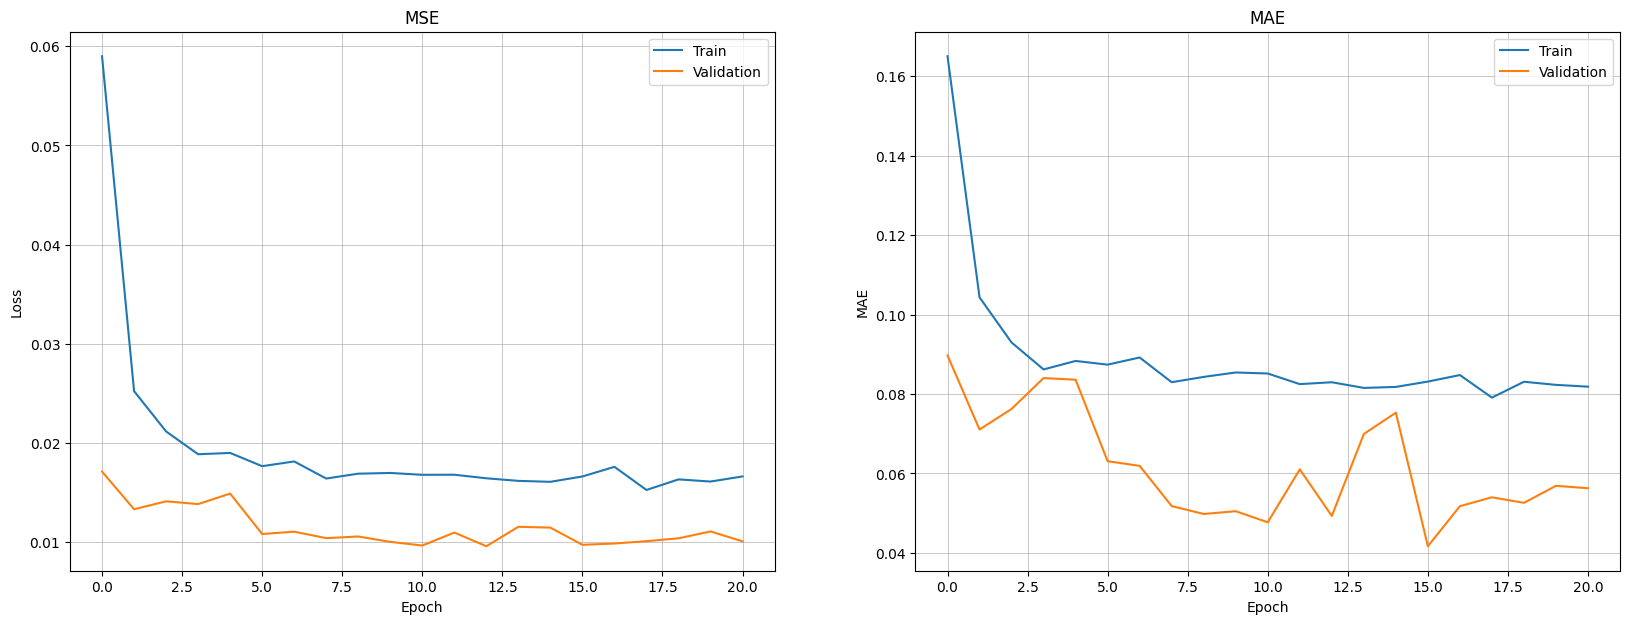

In [52]:
plot_history(history_3)

In [53]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[0.0018106541829183698, 0.030733002349734306]

In [54]:
res['model_3_score'] = res3[1]

In [55]:
y_pred_3 = model_3.predict(X_test)
y_pred_3

32/32 [==============================] - 0s 8ms/step


array([[0.2623377 ],
       [0.30702925],
       [0.28272253],
       [0.28202227],
       [0.27678096],
       [0.2804256 ],
       [0.2870641 ],
       [0.2775396 ],
       [0.2717402 ],
       [0.27236608],
       [0.27605873],
       [0.2718019 ],
       [0.27721554],
       [0.2838254 ],
       [0.2607925 ],
       [0.27546903],
       [0.15162376],
       [0.28572166],
       [0.27810788],
       [0.26831865],
       [0.15162376],
       [0.2726849 ],
       [0.17198661],
       [0.27250892],
       [0.27742478],
       [0.28069708],
       [0.27369338],
       [0.23694679],
       [0.27896866],
       [0.2695082 ],
       [0.27429038],
       [0.2753491 ],
       [0.27350444],
       [0.2639296 ],
       [0.27748695],
       [0.2743908 ],
       [0.27601445],
       [0.2905777 ],
       [0.2782392 ],
       [0.26735985],
       [0.2848242 ],
       [0.27170932],
       [0.2892585 ],
       [0.2905777 ],
       [0.2755512 ],
       [0.28258866],
       [0.26881588],
       [0.276

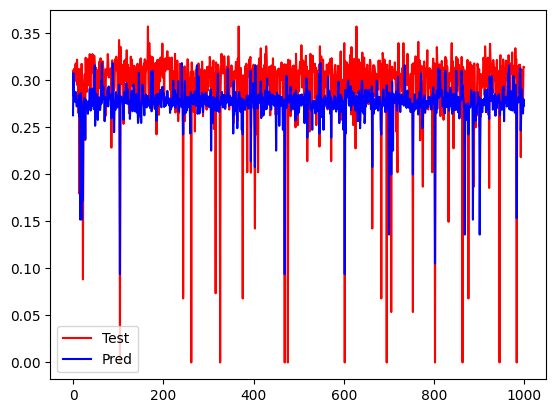

In [56]:
plot_predictions(y_test, y_pred_3)

In [57]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_3_unscaled = scaler_y.inverse_transform(y_pred_3)

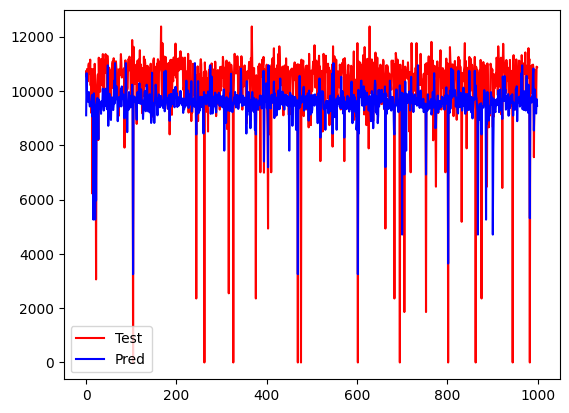

In [58]:
plot_predictions(y_test_unscaled, y_pred_3_unscaled)

### Model 4 - Changing learning rate

In [74]:
def init_model_4(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.4))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.01)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [75]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [76]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [77]:
model_4, history_4 = fit_model(model_4)

Epoch 1/50
110/110 [==============================] - 6s 44ms/step - loss: 0.0290 - mae: 0.1205 - val_loss: 0.0121 - val_mae: 0.0700
Epoch 2/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0145 - mae: 0.0800 - val_loss: 0.0108 - val_mae: 0.0658
Epoch 3/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0136 - mae: 0.0754 - val_loss: 0.0106 - val_mae: 0.0520
Epoch 4/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0130 - mae: 0.0709 - val_loss: 0.0098 - val_mae: 0.0523
Epoch 5/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0124 - mae: 0.0691 - val_loss: 0.0096 - val_mae: 0.0466
Epoch 6/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0124 - mae: 0.0706 - val_loss: 0.0101 - val_mae: 0.0607
Epoch 7/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0128 - mae: 0.0702 - val_loss: 0.0099 - val_mae: 0.0599
Epoch 8/50
110/110 [==============================] - 5s 43ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

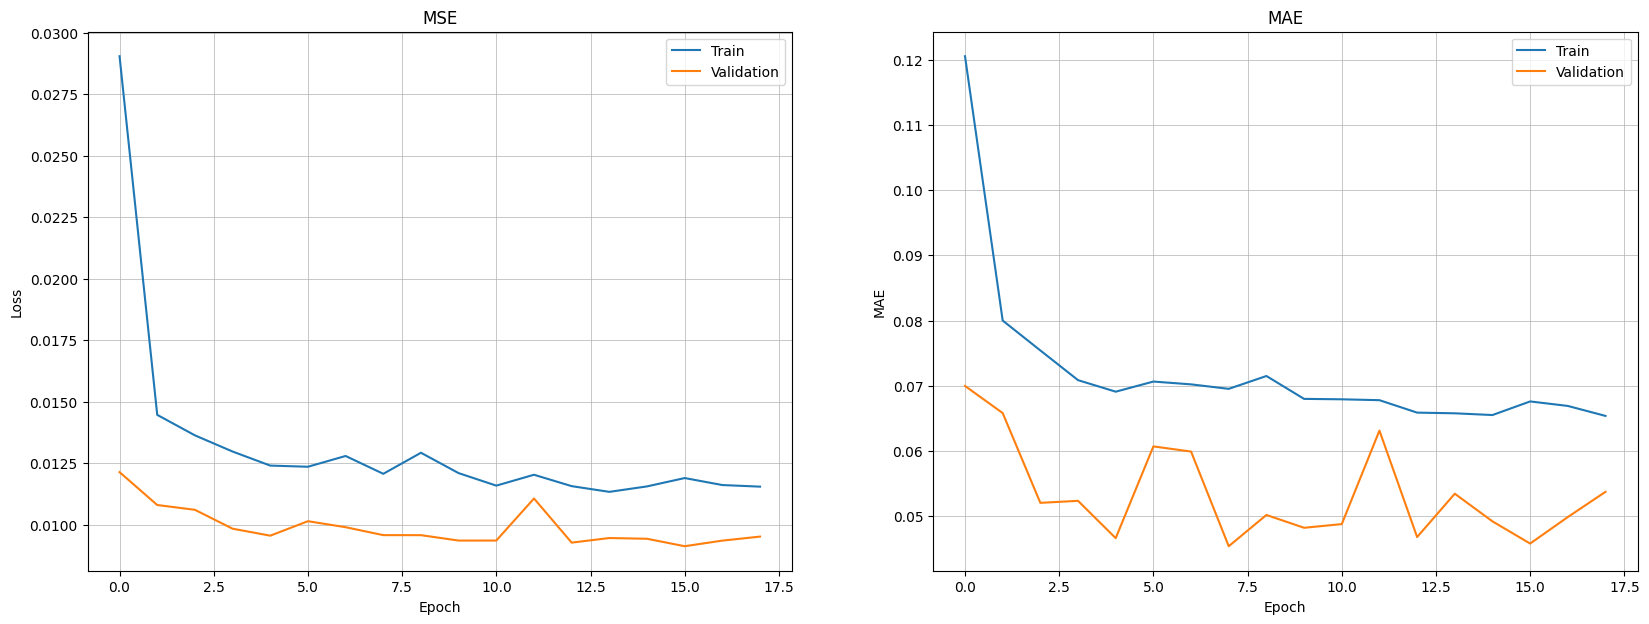

In [78]:
plot_history(history_4)

In [79]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[0.0017942633712664247, 0.03173057734966278]

In [80]:
res['model_4_score'] = res4[1]

In [81]:
y_pred_4 = model_4.predict(X_test)
y_pred_4

32/32 [==============================] - 0s 8ms/step


array([[0.27541363],
       [0.2863669 ],
       [0.27638212],
       [0.27443546],
       [0.27483273],
       [0.2749812 ],
       [0.2788451 ],
       [0.27390814],
       [0.28170374],
       [0.28002268],
       [0.26914895],
       [0.27878055],
       [0.26984602],
       [0.27681252],
       [0.25311702],
       [0.27423623],
       [0.18685332],
       [0.27554786],
       [0.2749819 ],
       [0.28050658],
       [0.18685332],
       [0.27055877],
       [0.17171922],
       [0.27370209],
       [0.27272755],
       [0.27393255],
       [0.2799148 ],
       [0.24813965],
       [0.27803466],
       [0.2802491 ],
       [0.26937285],
       [0.27360684],
       [0.28059062],
       [0.2514307 ],
       [0.2692627 ],
       [0.26918334],
       [0.27438718],
       [0.27863705],
       [0.27428514],
       [0.27752537],
       [0.27710086],
       [0.2812125 ],
       [0.27928913],
       [0.27863705],
       [0.28461802],
       [0.2764632 ],
       [0.27047008],
       [0.283

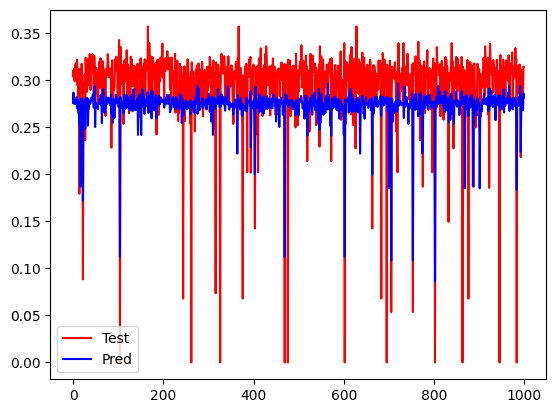

In [82]:
plot_predictions(y_test, y_pred_4)

In [83]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_4_unscaled = scaler_y.inverse_transform(y_pred_4)

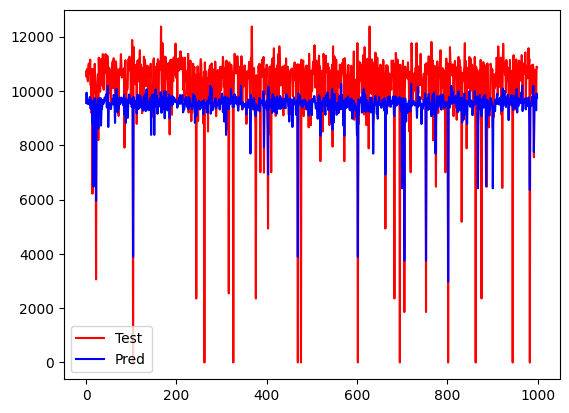

In [84]:
plot_predictions(y_test_unscaled, y_pred_4_unscaled)

### Model 5 - Trying to find the best model

In [85]:
def init_model_5(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [86]:
model_5 = init_model_5(X_train, y_train)
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [87]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [88]:
model_5, history_5 = fit_model(model_5)

Epoch 1/50
110/110 [==============================] - 6s 44ms/step - loss: 0.0484 - mae: 0.1567 - val_loss: 0.0209 - val_mae: 0.0980
Epoch 2/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0164 - mae: 0.0839 - val_loss: 0.0128 - val_mae: 0.0673
Epoch 3/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0120 - mae: 0.0673 - val_loss: 0.0117 - val_mae: 0.0604
Epoch 4/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0116 - mae: 0.0648 - val_loss: 0.0104 - val_mae: 0.0561
Epoch 5/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0112 - mae: 0.0622 - val_loss: 0.0104 - val_mae: 0.0550
Epoch 6/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0100 - mae: 0.0578 - val_loss: 0.0094 - val_mae: 0.0435
Epoch 7/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0110 - mae: 0.0620 - val_loss: 0.0106 - val_mae: 0.0554
Epoch 8/50
110/110 [==============================] - 5s 43ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

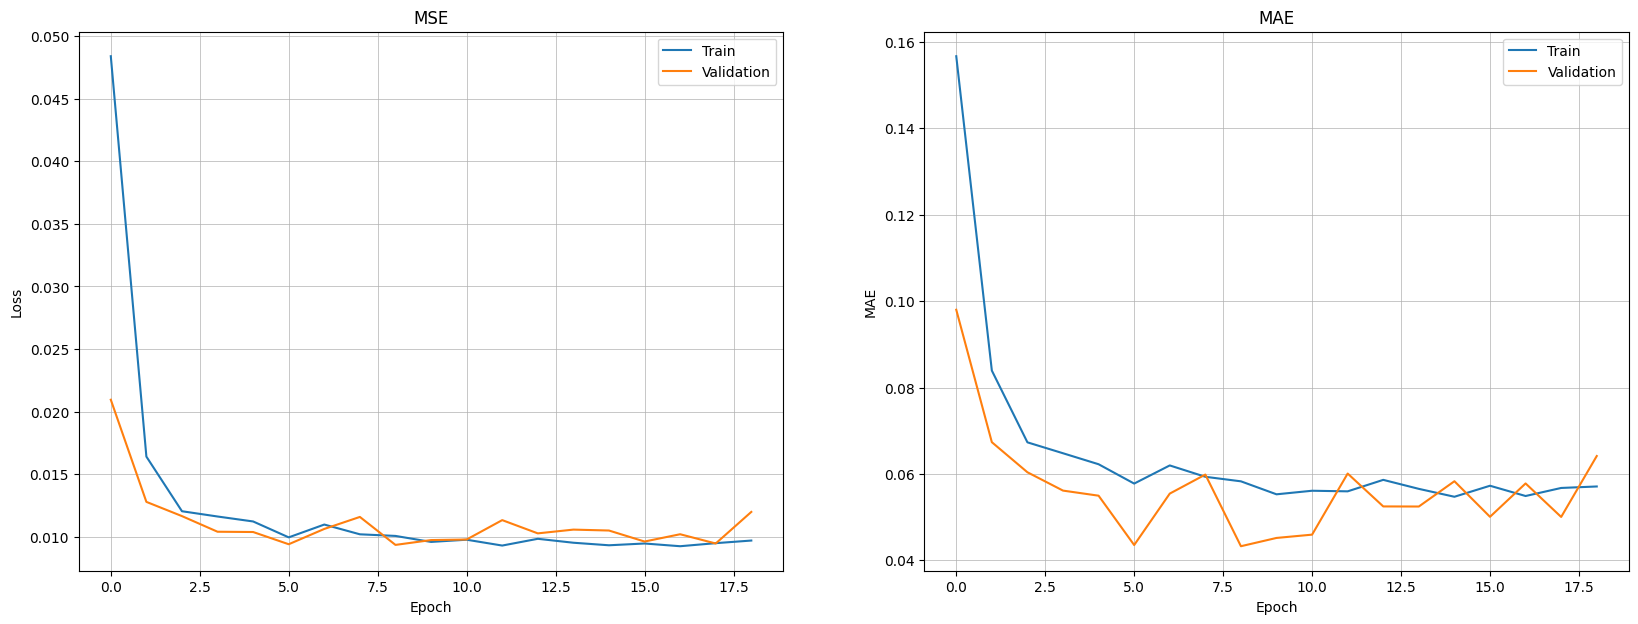

In [89]:
plot_history(history_5)

In [90]:
res5 = model_5.evaluate(X_test, y_test, verbose=0)
res5

[0.0015196561580523849, 0.025329547002911568]

In [91]:
res['model_5_score'] = res5[1]

In [92]:
y_pred_5 = model_5.predict(X_test)
y_pred_5

32/32 [==============================] - 0s 8ms/step


array([[0.2815732 ],
       [0.3036775 ],
       [0.28816304],
       [0.2780406 ],
       [0.27562937],
       [0.28630924],
       [0.29102188],
       [0.27690458],
       [0.29149607],
       [0.29298556],
       [0.2729802 ],
       [0.29079688],
       [0.27652338],
       [0.2874549 ],
       [0.2305009 ],
       [0.27020392],
       [0.11006594],
       [0.2911019 ],
       [0.2754912 ],
       [0.28968948],
       [0.11006594],
       [0.26786378],
       [0.09324551],
       [0.27531272],
       [0.27449787],
       [0.27379274],
       [0.29195762],
       [0.23381561],
       [0.2888548 ],
       [0.288517  ],
       [0.28038383],
       [0.27279365],
       [0.2935412 ],
       [0.27456743],
       [0.28539366],
       [0.27106243],
       [0.28435847],
       [0.28719294],
       [0.2758005 ],
       [0.28658715],
       [0.29037356],
       [0.29126906],
       [0.29112387],
       [0.28719294],
       [0.2958368 ],
       [0.28722066],
       [0.2694524 ],
       [0.294

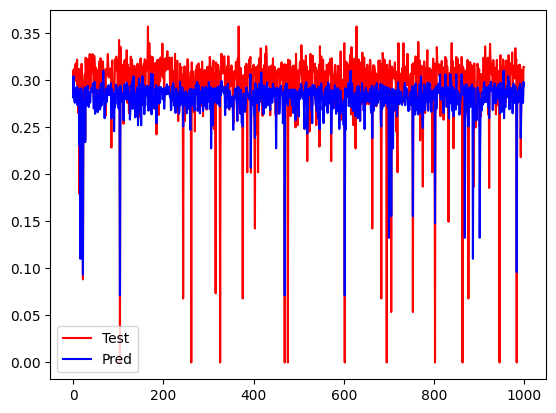

In [93]:
plot_predictions(y_test, y_pred_5)

In [94]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_5_unscaled = scaler_y.inverse_transform(y_pred_5)

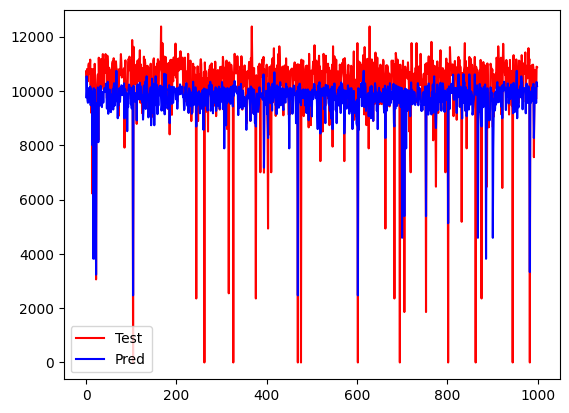

In [95]:
plot_predictions(y_test_unscaled, y_pred_5_unscaled)

### Model 6 - Changing optimizer

In [96]:
def init_model_6(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    nadam = optimizers.Nadam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=nadam,
                 metrics=['mae'])
    
    return model

In [97]:
model_6 = init_model_6(X_train, y_train)
model_6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [98]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [99]:
model_6, history_6 = fit_model(model_6)

Epoch 1/50
110/110 [==============================] - 6s 44ms/step - loss: 0.0275 - mae: 0.1105 - val_loss: 0.0231 - val_mae: 0.1132
Epoch 2/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0129 - mae: 0.0737 - val_loss: 0.0144 - val_mae: 0.0764
Epoch 3/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0114 - mae: 0.0670 - val_loss: 0.0208 - val_mae: 0.1085
Epoch 4/50
110/110 [==============================] - 5s 42ms/step - loss: 0.0112 - mae: 0.0663 - val_loss: 0.0129 - val_mae: 0.0650
Epoch 5/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0106 - mae: 0.0623 - val_loss: 0.0157 - val_mae: 0.0855
Epoch 6/50
110/110 [==============================] - 5s 45ms/step - loss: 0.0100 - mae: 0.0605 - val_loss: 0.0165 - val_mae: 0.0850
Epoch 7/50
110/110 [==============================] - 5s 43ms/step - loss: 0.0103 - mae: 0.0615 - val_loss: 0.0167 - val_mae: 0.0859
Epoch 8/50
110/110 [==============================] - 5s 43ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

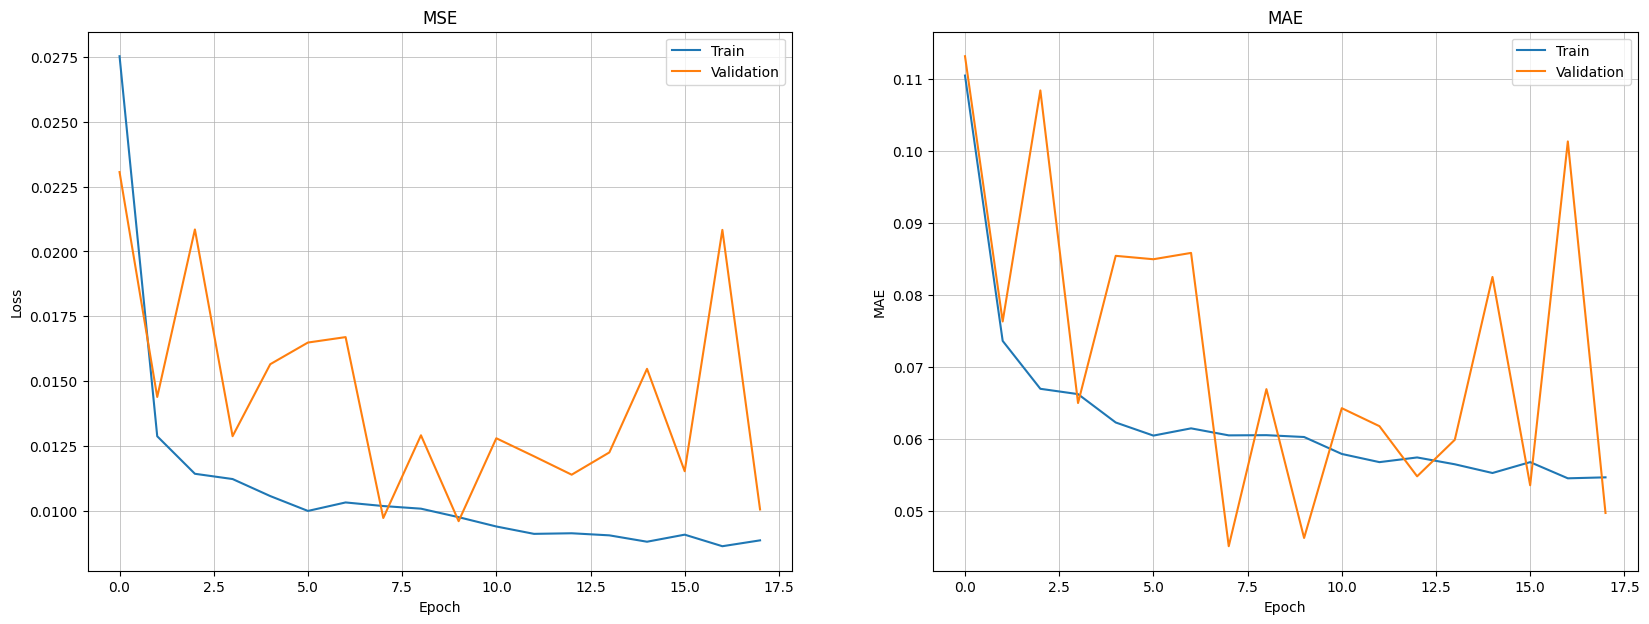

In [100]:
plot_history(history_6)

In [101]:
res6 = model_6.evaluate(X_test, y_test, verbose=0)
res6

[0.0021266452968120575, 0.03669685497879982]

In [102]:
res['model_6_score'] = res6[1]

In [103]:
y_pred_6 = model_6.predict(X_test)
y_pred_6

32/32 [==============================] - 0s 7ms/step


array([[ 0.2680605 ],
       [ 0.28337133],
       [ 0.27494094],
       [ 0.2602299 ],
       [ 0.26847404],
       [ 0.27382782],
       [ 0.27608147],
       [ 0.27045617],
       [ 0.27343747],
       [ 0.27351385],
       [ 0.25739795],
       [ 0.27135667],
       [ 0.26092502],
       [ 0.27528453],
       [ 0.28570908],
       [ 0.25990242],
       [ 0.17045313],
       [ 0.27330527],
       [ 0.26849934],
       [ 0.27317908],
       [ 0.17045313],
       [ 0.25462508],
       [ 0.07290435],
       [ 0.26044518],
       [ 0.26513743],
       [ 0.26839456],
       [ 0.272525  ],
       [ 0.24323493],
       [ 0.27517518],
       [ 0.27298093],
       [ 0.26564384],
       [ 0.26733163],
       [ 0.27387953],
       [ 0.23474231],
       [ 0.2667206 ],
       [ 0.25742263],
       [ 0.27277148],
       [ 0.26986456],
       [ 0.2589995 ],
       [ 0.26924455],
       [ 0.27531114],
       [ 0.2730377 ],
       [ 0.27718845],
       [ 0.26986456],
       [ 0.277744  ],
       [ 0

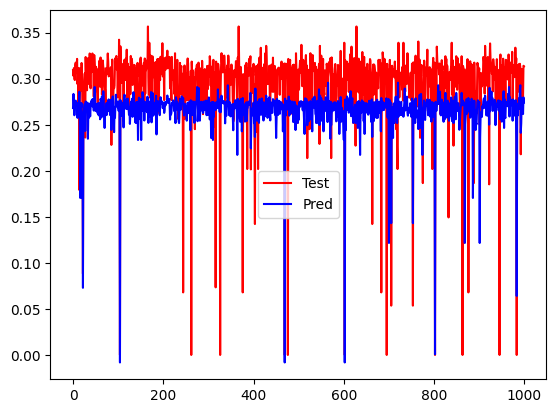

In [104]:
plot_predictions(y_test, y_pred_6)

In [105]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_6_unscaled = scaler_y.inverse_transform(y_pred_6)

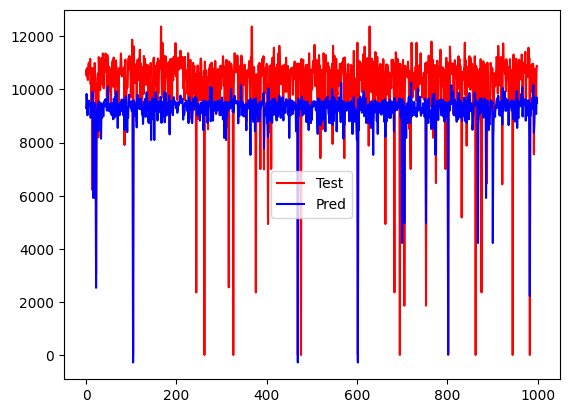

In [106]:
plot_predictions(y_test_unscaled, y_pred_6_unscaled)

### Model 7 - Changing batch size = 16

In [107]:
def init_model_7(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [108]:
model_7 = init_model_7(X_train, y_train)
model_7.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [109]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [110]:
model_7, history_7 = fit_model(model_7)

Epoch 1/50
219/219 [==============================] - 10s 42ms/step - loss: 0.0308 - mae: 0.1142 - val_loss: 0.0159 - val_mae: 0.0990
Epoch 2/50
219/219 [==============================] - 9s 41ms/step - loss: 0.0121 - mae: 0.0666 - val_loss: 0.0106 - val_mae: 0.0568
Epoch 3/50
219/219 [==============================] - 9s 41ms/step - loss: 0.0118 - mae: 0.0674 - val_loss: 0.0151 - val_mae: 0.0918
Epoch 4/50
219/219 [==============================] - 9s 41ms/step - loss: 0.0111 - mae: 0.0642 - val_loss: 0.0119 - val_mae: 0.0828
Epoch 5/50
219/219 [==============================] - 9s 41ms/step - loss: 0.0112 - mae: 0.0641 - val_loss: 0.0111 - val_mae: 0.0761
Epoch 6/50
219/219 [==============================] - 9s 41ms/step - loss: 0.0105 - mae: 0.0606 - val_loss: 0.0118 - val_mae: 0.0833
Epoch 7/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0107 - mae: 0.0628 - val_loss: 0.0129 - val_mae: 0.0912
Epoch 8/50
219/219 [==============================] - 9s 41ms/step -

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

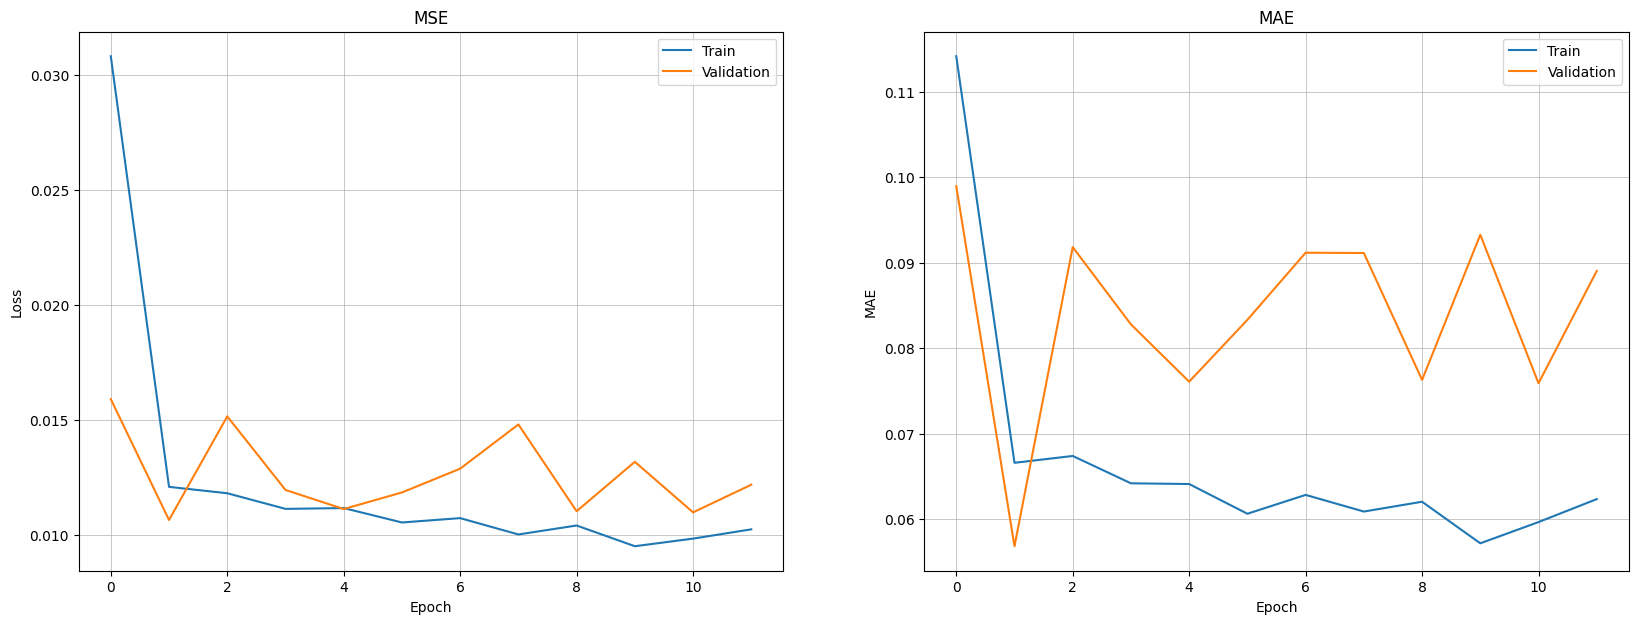

In [111]:
plot_history(history_7)

In [112]:
res7 = model_7.evaluate(X_test, y_test, verbose=0)
res7

[0.0018365919822826982, 0.02507651597261429]

In [113]:
res['model_7_score'] = res7[1]

In [114]:
y_pred_7 = model_7.predict(X_test)
y_pred_7

32/32 [==============================] - 0s 8ms/step


array([[0.3231926 ],
       [0.32828814],
       [0.32132113],
       [0.31226242],
       [0.3196273 ],
       [0.31957966],
       [0.32158607],
       [0.31729633],
       [0.3290661 ],
       [0.32555443],
       [0.30980495],
       [0.3271052 ],
       [0.31672043],
       [0.32314724],
       [0.30960196],
       [0.30743822],
       [0.22232758],
       [0.3208631 ],
       [0.31941694],
       [0.3276113 ],
       [0.22232758],
       [0.30424452],
       [0.18344769],
       [0.3041046 ],
       [0.31136578],
       [0.3076597 ],
       [0.32536867],
       [0.2901654 ],
       [0.31823748],
       [0.32725126],
       [0.31378734],
       [0.31893614],
       [0.3305952 ],
       [0.31298673],
       [0.3147417 ],
       [0.31149647],
       [0.31713188],
       [0.3215556 ],
       [0.31065762],
       [0.32853103],
       [0.32316053],
       [0.33001083],
       [0.32597813],
       [0.3215556 ],
       [0.33185136],
       [0.31958216],
       [0.31438154],
       [0.335

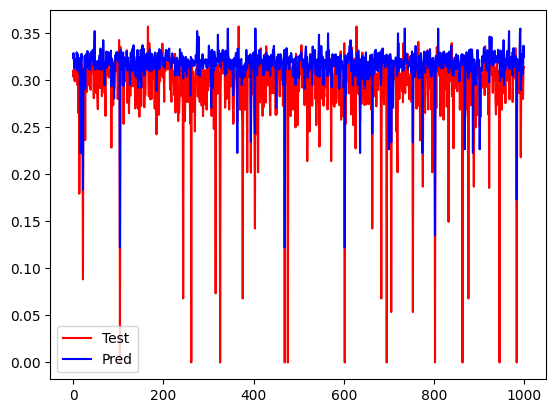

In [115]:
plot_predictions(y_test, y_pred_7)

In [116]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_7_unscaled = scaler_y.inverse_transform(y_pred_7)

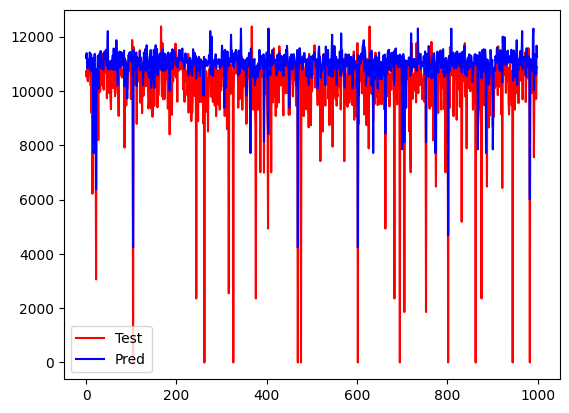

In [117]:
plot_predictions(y_test_unscaled, y_pred_7_unscaled)

### Model 8 - Changing batch size = 64

In [118]:
def init_model_8(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [119]:
model_8 = init_model_8(X_train, y_train)
model_8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [120]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [121]:
model_8, history_8 = fit_model(model_8)

Epoch 1/50
55/55 [==============================] - 4s 51ms/step - loss: 0.0597 - mae: 0.1714 - val_loss: 0.0243 - val_mae: 0.1079
Epoch 2/50
55/55 [==============================] - 3s 47ms/step - loss: 0.0212 - mae: 0.0970 - val_loss: 0.0123 - val_mae: 0.0704
Epoch 3/50
55/55 [==============================] - 3s 48ms/step - loss: 0.0133 - mae: 0.0722 - val_loss: 0.0104 - val_mae: 0.0585
Epoch 4/50
55/55 [==============================] - 3s 47ms/step - loss: 0.0117 - mae: 0.0644 - val_loss: 0.0098 - val_mae: 0.0510
Epoch 5/50
55/55 [==============================] - 3s 47ms/step - loss: 0.0111 - mae: 0.0623 - val_loss: 0.0098 - val_mae: 0.0558
Epoch 6/50
55/55 [==============================] - 3s 48ms/step - loss: 0.0106 - mae: 0.0586 - val_loss: 0.0096 - val_mae: 0.0510
Epoch 7/50
55/55 [==============================] - 3s 47ms/step - loss: 0.0112 - mae: 0.0598 - val_loss: 0.0096 - val_mae: 0.0457
Epoch 8/50
55/55 [==============================] - 3s 47ms/step - loss: 0.0103 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

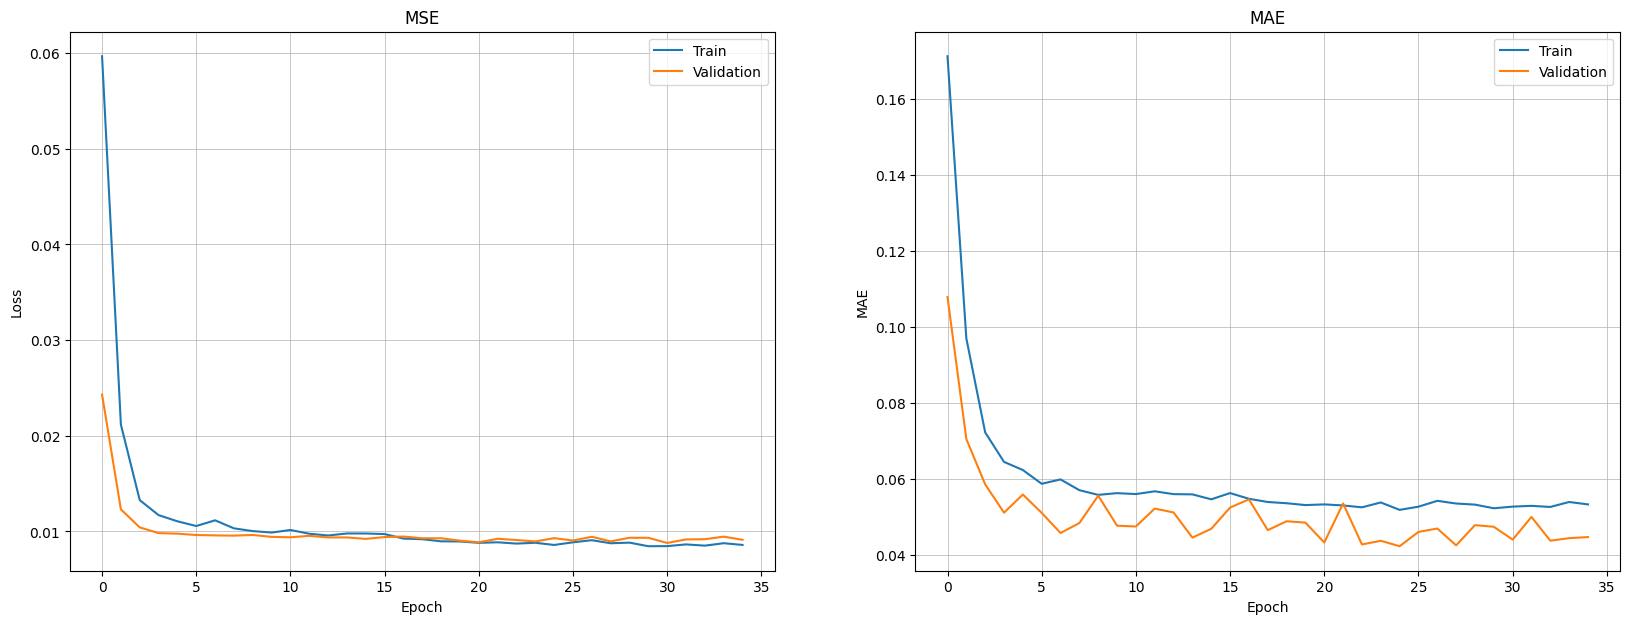

In [122]:
plot_history(history_8)

In [123]:
res8 = model_8.evaluate(X_test, y_test, verbose=0)
res8

[0.001380859175696969, 0.022292515262961388]

In [124]:
res['model_8_score'] = res8[1]

In [125]:
y_pred_8 = model_8.predict(X_test)
y_pred_8

32/32 [==============================] - 0s 8ms/step


array([[0.28709453],
       [0.30508274],
       [0.2901332 ],
       [0.27983388],
       [0.28046107],
       [0.29127708],
       [0.29666665],
       [0.28664267],
       [0.29661682],
       [0.30346954],
       [0.2775442 ],
       [0.29863995],
       [0.27775362],
       [0.29191637],
       [0.24295646],
       [0.27787805],
       [0.14677277],
       [0.29444963],
       [0.28196645],
       [0.29819512],
       [0.14677277],
       [0.2719616 ],
       [0.05416572],
       [0.27189976],
       [0.28269187],
       [0.2743938 ],
       [0.2980919 ],
       [0.25719735],
       [0.29410124],
       [0.29374385],
       [0.28421193],
       [0.27898532],
       [0.30308723],
       [0.26765212],
       [0.27994484],
       [0.27468628],
       [0.28864145],
       [0.2950169 ],
       [0.27751398],
       [0.2916326 ],
       [0.29191434],
       [0.29921633],
       [0.29492527],
       [0.2950169 ],
       [0.3000651 ],
       [0.2941946 ],
       [0.2766176 ],
       [0.301

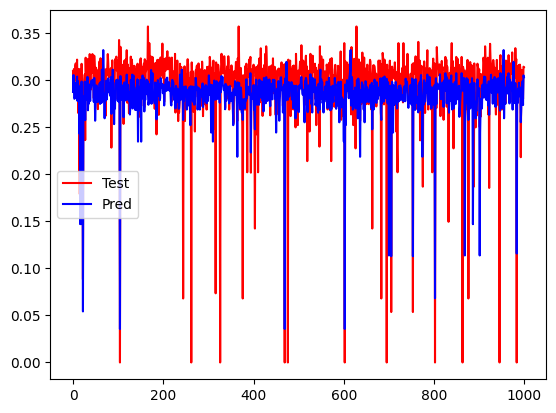

In [126]:
plot_predictions(y_test, y_pred_8)

In [127]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_8_unscaled = scaler_y.inverse_transform(y_pred_8)

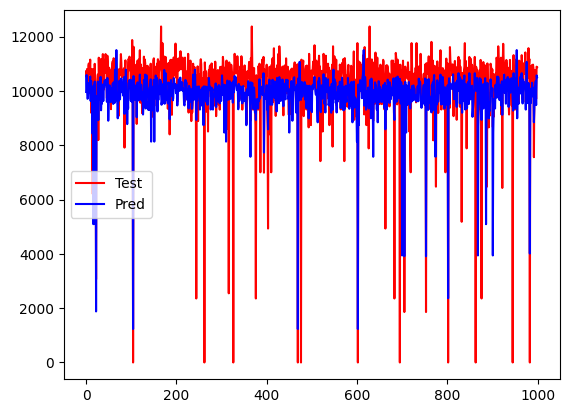

In [128]:
plot_predictions(y_test_unscaled, y_pred_8_unscaled)

### Model 9 - Using kernel regularizers

In [129]:
from tensorflow.keras import regularizers

In [130]:
def init_model_9(X_train, y_train):
    
    reg = regularizers.l1_l2(l1=0.005)
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [131]:
model_9 = init_model_9(X_train, y_train)
model_9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [132]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [133]:
model_9, history_9 = fit_model(model_9)

Epoch 1/50
219/219 [==============================] - 10s 42ms/step - loss: 0.1072 - mae: 0.1405 - val_loss: 0.0476 - val_mae: 0.1036
Epoch 2/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0448 - mae: 0.1012 - val_loss: 0.0373 - val_mae: 0.0755
Epoch 3/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0423 - mae: 0.0983 - val_loss: 0.0409 - val_mae: 0.0887
Epoch 4/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0423 - mae: 0.0953 - val_loss: 0.0407 - val_mae: 0.0777
Epoch 5/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0428 - mae: 0.0973 - val_loss: 0.0339 - val_mae: 0.0655
Epoch 6/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0415 - mae: 0.0953 - val_loss: 0.0495 - val_mae: 0.1148
Epoch 7/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0425 - mae: 0.0963 - val_loss: 0.0428 - val_mae: 0.0938
Epoch 8/50
219/219 [==============================] - 9s 42ms/step -

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

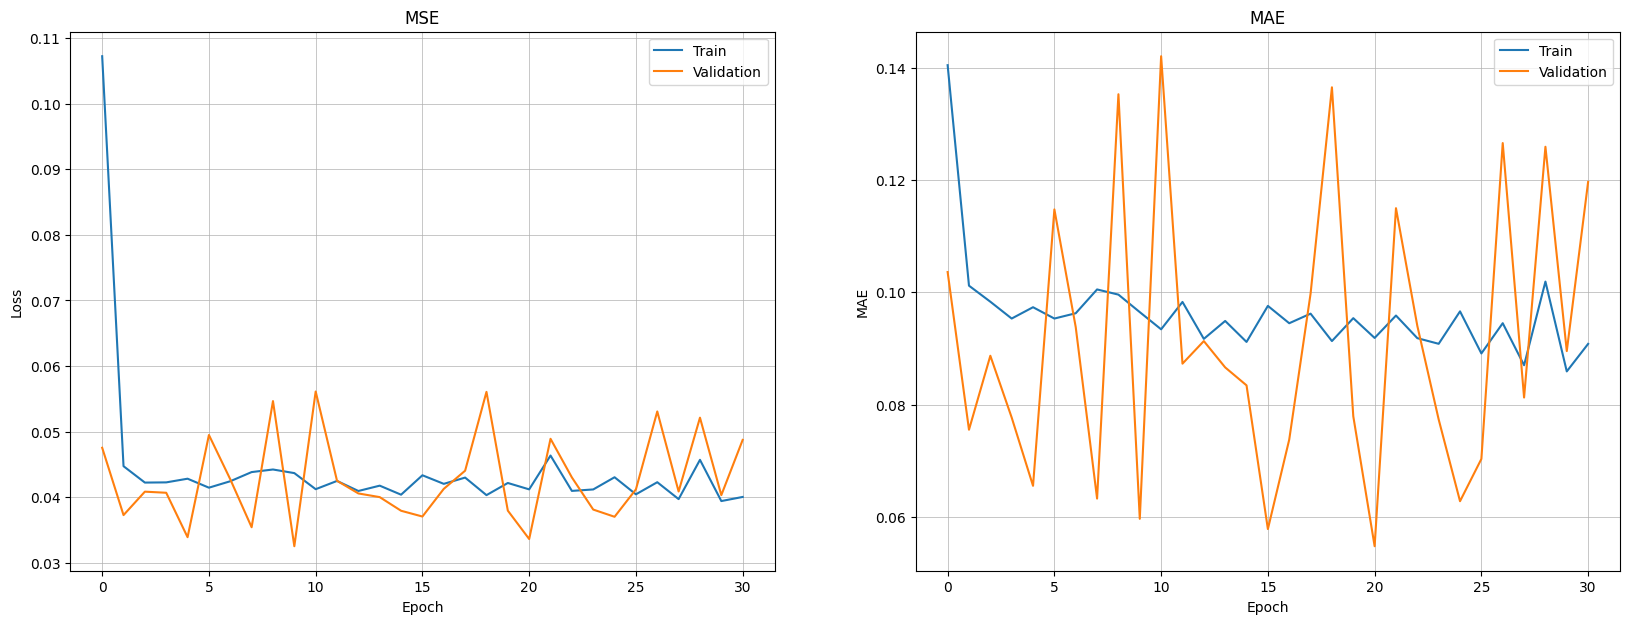

In [134]:
plot_history(history_9)

In [135]:
res9 = model_9.evaluate(X_test, y_test, verbose=0)
res9

[0.024402109906077385, 0.019101908430457115]

In [136]:
res['model_9_score'] = res9[1]

In [137]:
y_pred_9 = model_9.predict(X_test)
y_pred_9

32/32 [==============================] - 0s 8ms/step


array([[0.30147314],
       [0.31845558],
       [0.3170218 ],
       [0.31262702],
       [0.30753505],
       [0.31732145],
       [0.3227889 ],
       [0.31358713],
       [0.313014  ],
       [0.31593812],
       [0.31073213],
       [0.31551567],
       [0.3030017 ],
       [0.3171332 ],
       [0.19742395],
       [0.30864117],
       [0.300968  ],
       [0.31991184],
       [0.31174666],
       [0.3162945 ],
       [0.300968  ],
       [0.30338833],
       [0.2375905 ],
       [0.3140844 ],
       [0.33324134],
       [0.3085593 ],
       [0.31028393],
       [0.2736819 ],
       [0.32315278],
       [0.3103529 ],
       [0.3091079 ],
       [0.30411345],
       [0.31475323],
       [0.25193894],
       [0.30390698],
       [0.3087358 ],
       [0.3156255 ],
       [0.32356933],
       [0.31095108],
       [0.30662972],
       [0.32080683],
       [0.31311816],
       [0.32253182],
       [0.32356933],
       [0.31651044],
       [0.32044828],
       [0.3021108 ],
       [0.318

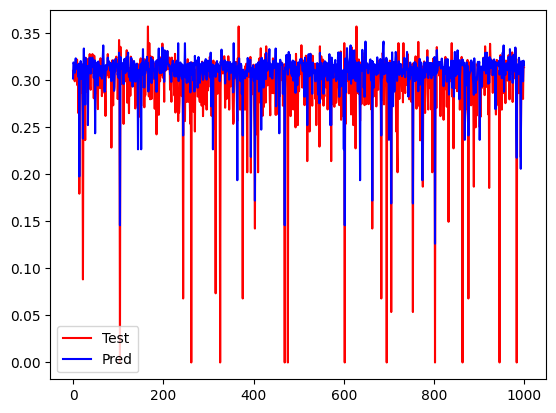

In [138]:
plot_predictions(y_test, y_pred_9)

In [139]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_9_unscaled = scaler_y.inverse_transform(y_pred_9)

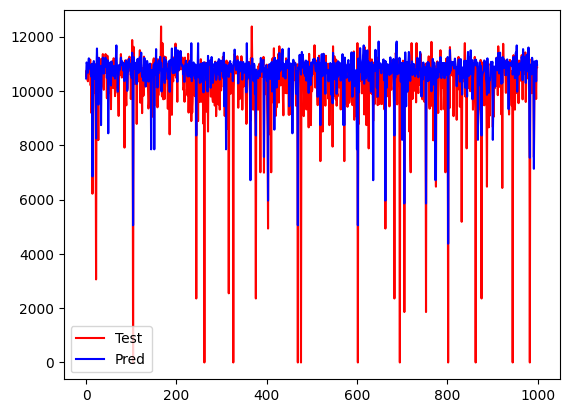

In [140]:
plot_predictions(y_test_unscaled, y_pred_9_unscaled)

## Choosing the best model

In [141]:
baseline_score[1]

0.03702442720532417

In [142]:
res

{'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04049758240580559,
 'model_2_score': 0.02823290042579174,
 'model_3_score': 0.030733002349734306,
 'model_4_score': 0.03173057734966278,
 'model_5_score': 0.025329547002911568,
 'model_6_score': 0.03669685497879982,
 'model_7_score': 0.02507651597261429,
 'model_8_score': 0.022292515262961388,
 'model_9_score': 0.019101908430457115}

In [143]:
for key, value in res.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -9.38 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 23.75 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 16.99 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 14.3 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 31.59 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 0.88 % 

🏋🏽‍♂️ model_7_score improvement over baseline: 32.27 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 39.79 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 48.41 % 



In [144]:
def find_min_model_score(dic):
    min_score = min(dic.values())
    min_model = [k for k in dic if dic[k] == min_score]
    return min_model, min_score

In [147]:
min_model, min_score = find_min_model_score(res)
print(f"The model with the lowest score {min_score} is {min_model}")

The model with the lowest score 0.019101908430457115 is ['model_9_score']


###### Be careful running the next cells. Try to save the results for each run

In [151]:
best_models_run_1 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04049758240580559,
 'model_2_score': 0.02823290042579174,
 'model_3_score': 0.030733002349734306,
 'model_4_score': 0.03173057734966278,
 'model_5_score': 0.025329547002911568,
 'model_6_score': 0.03669685497879982,
 'model_7_score': 0.02507651597261429,
 'model_8_score': 0.022292515262961388,
 'model_9_score': 0.019101908430457115}
best_models_run_1

{'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04049758240580559,
 'model_2_score': 0.02823290042579174,
 'model_3_score': 0.030733002349734306,
 'model_4_score': 0.03173057734966278,
 'model_5_score': 0.025329547002911568,
 'model_6_score': 0.03669685497879982,
 'model_7_score': 0.02507651597261429,
 'model_8_score': 0.022292515262961388,
 'model_9_score': 0.019101908430457115}

In [152]:
for key, value in best_models_run_1.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -9.38 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 23.75 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 16.99 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 14.3 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 31.59 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 0.88 % 

🏋🏽‍♂️ model_7_score improvement over baseline: 32.27 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 39.79 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 48.41 % 

